In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
from pathlib import Path
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, pmap, grad, debug, tree, lax, value_and_grad
jconfig.update("jax_enable_x64", True)
print(jdevices())

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname
#!jupyter nbconvert --to python /dvs_ro/u1/h/hsimfroy/workspace/montecosmo_proj/src/montecosmo/tests/infer_model2.ipynb

# save_dir = Path("./save/")
# save_dir = Path(os.path.expanduser("~/scratch/png/abacus_c0_i0_z08_lrg/test")) # FMN
# load_dir = Path(os.path.expanduser("~/scratch/png/abacus_c0_i0_z08_lrg/load/")) # FMN
# save_dir = Path("/lustre/fsn1/projects/rech/fvg/uvs19wt/png/") # JZ
# save_dir = Path("/lustre/fswork/projects/rech/fvg/uvs19wt/workspace/png/") # JZ
save_dir = Path("/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z08_lrg/noise") # Perlmutter
# load_dir = Path("/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z08_lrg/load/") # Perlmutter
load_dir = Path("/pscratch/sd/h/hsimfroy/png/fpm_b2760_z05_lrg_fNL/load/") # Perlmutter
# save_path = save_dir / "test"
save_dir.mkdir(parents=True, exist_ok=True)

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]
nid001056


/global/u1/h/hsimfroy/miniforge3/envs/montenv/lib/python3.14/pty.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
# # Abacus initial
from montecosmo.metrics import spectrum
from montecosmo.plot import plot_pow
init_mesh = jnp.fft.rfftn(jnp.load(load_dir / f"init_mesh_fake_2760_{256}.npy"))
kpow_init = spectrum(jnp.fft.irfftn(init_mesh), box_size=3*(2760,))
plot_pow(*kpow_init, label='init_mesh')

In [ ]:
from montecosmo.utils import ch2rshape, r2chshape
from montecosmo.nbody import rfftk, fftk
from montecosmo.plot import plot_mesh

def chreshape(mesh, shape):
    """
    Reshape a complex Hermitian tensor (3D),
    handling correctly zero-padding.
    """
    ids_shape = tuple(np.minimum(mesh.shape, shape))
    scale = np.divide(ch2rshape(shape), ch2rshape(mesh.shape)).prod()
    ids = tuple(np.roll(np.arange(-(s//2), (s+1)//2), -(s//2)) for s in ids_shape[:-1])
    ids += (np.arange(ids_shape[-1]),)
    
    if ids_shape == shape: # downsample all axis
        out = mesh[np.ix_(*ids)]
    elif ids_shape == mesh.shape: # oversample all axis
        out = jnp.zeros(shape, dtype=complex)
        out = out.at[np.ix_(*ids)].set(mesh)
    else: # down or oversample
        out = jnp.zeros(shape, dtype=complex)
        ids = np.ix_(*ids)
        out = out.at[ids].set(mesh[ids])
    return out * scale

def chreshape2(mesh, shape):
    scale = np.divide(ch2rshape(shape), ch2rshape(mesh.shape)).prod()

    # Center wavevectors in mesh to truncate or pad
    for ax, s in enumerate(mesh.shape[:-1]):
        mesh = np.roll(mesh, s//2, ax)
    
    slices = ()
    for ax, (ms, s) in enumerate(zip(mesh.shape, shape)):
        trunc = max(ms - s, 0)
        if ax < len(shape) - 1:
            trunc //= 2
            slices += (slice(trunc, None if trunc==0 else -trunc),)
        else:
            slices += (slice(0, None if trunc==0 else -trunc),)
    mesh = mesh[slices]

    pad_width = ()
    for ax, (ms, s) in enumerate(zip(mesh.shape, shape)):
        pad = max(s - ms, 0)
        if ax < len(shape) - 1:
            pad //= 2
            pad_width += ((pad, pad),)
        else:
            pad_width += ((0,pad),)
    mesh = jnp.pad(mesh, pad_width=pad_width)

    # Decenter wavevectors in mesh after truncate or pad
    for ax, s in enumerate(mesh.shape[:-1]):
        mesh = np.roll(mesh, -s//2, ax)
    return mesh * scale


In [51]:
shape = 3*(32,)
shape1 = r2chshape((26,34,26))
kvec = rfftk(shape)
# kvec = fftk(shape)
kmesh = sum(ki**2 for ki in kvec)
print(kmesh.shape)

kmesh1 = chreshape(kmesh, shape1)
kmesh2 = chreshape2(kmesh, shape1)
print(kmesh1.dtype, kmesh2.dtype)

axis = 0
plt.figure(figsize=(12,3.5), layout='constrained')
plt.subplot(141)
plot_mesh(kmesh.real, ids=0.1, axis=axis)
plt.subplot(142)
plot_mesh(kmesh1.real - kmesh2.real, ids=0.1, axis=axis)
plt.colorbar()
plt.subplot(143)
plot_mesh(kmesh1.real, ids=0.1, axis=axis)
plt.subplot(144)
plot_mesh(kmesh2.real, ids=0.1, axis=axis)
np.allclose(kmesh1, kmesh2)

(32, 32, 17)
complex128 float64


True

In [44]:
%%timeit
kmesh1 = jnp.abs(chreshape(kmesh, shape1))

205 μs ± 5.6 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit
kmesh2 = jnp.abs(chreshape2(kmesh, shape1))

480 μs ± 56.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


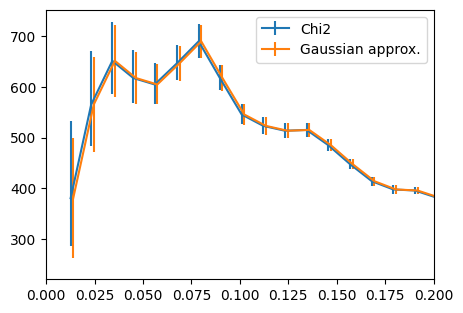

In [37]:
# delta_obs0 = jnp.load(load_dir / f'tracer_6746545_paint2_deconv1_{576}.npy') - 1

from montecosmo.plot import plot_mesh, plot_pow, theme
from montecosmo.metrics import spectrum
from montecosmo.nbody import rectangular_hat, deconv_paint, rfftk
from montecosmo.bricks import lin_power_mesh, AbacusSummit0

mesh_shape = np.array(3*(64,))
box_size = np.array(3*(1000,))  # Mpc/h
cosmo = AbacusSummit0()
pmesh = lin_power_mesh(cosmo, mesh_shape, box_size)

kvec = rfftk(mesh_shape)
mesh = jr.normal(jr.key(42), mesh_shape)
mesh = jnp.fft.rfftn(mesh)
mesh *= pmesh**.5
mesh = jnp.fft.irfftn(mesh)
kpow = spectrum(mesh, box_size=box_size)

from montecosmo.metrics import _waves
from montecosmo.utils import safe_div

def spetrum_kcount(mesh_shape, box_size, kedges:int|float|list=None, box_center:tuple=(0.,0.,0.)):
    # Initialize
    box_center = np.asarray(box_center)
    los = safe_div(box_center, np.linalg.norm(box_center))
    kedges, kmesh, mumesh, rfftw = _waves(mesh_shape, box_size, kedges, los)
    n_bins = len(kedges) + 1
    dig = np.digitize(kmesh.reshape(-1), kedges)

    # Count wavenumber in bins
    kcount = np.bincount(dig, weights=rfftw.reshape(-1), minlength=n_bins)[1:-1]
    return kcount

kcount = spetrum_kcount(mesh_shape, box_size)

def pow_error_bars(kcount, pow, confidence=0.95, gaussian_approx=False):
    from scipy.stats import chi2, norm
    if not gaussian_approx:
        low, high = chi2(df=kcount).interval(confidence)
        low, high = pow * kcount / high, pow * kcount / low
        low, high = pow - low, high - pow
        yerr = jnp.stack((low, high))
    else:
        low = pow * (2 / kcount)**.5 * norm.interval(confidence)[1]
        yerr = jnp.stack((low, low))
    return yerr

# from scipy.stats import chi2, norm
# confidence = 0.95
# low, high = chi2(df=kcount).interval(confidence)
# low, high = kpow[1] * kcount / high, kpow[1] * kcount / low
# low, high = kpow[1] - low, high - kpow[1]
# yerr = jnp.stack((low, high))

# # low = 20000*(2 / kcount)**.5
# low = kpow[1] * (2 / kcount)**.5 * norm.interval(confidence)[1]
# yerr_norm = jnp.stack((low, low))

yerr = pow_error_bars(kcount, kpow[1], confidence=0.95, gaussian_approx=False)
yerr_norm = pow_error_bars(kcount, kpow[1], confidence=0.95, gaussian_approx=True)

plt.figure(figsize=(5,3.5))
# plot_pow(*kpow, label='truc')
plt.errorbar(kpow[0], kpow[0] * kpow[1], yerr=kpow[0] * yerr, label="Chi2")
# eb = plt.errorbar(kpow[0], kpow[0] * kpow[1], yerr=kpow[0] * yerr_norm, ls=':')
# eb[-1][0].set_linestyle('-.')
plt.errorbar(kpow[0]+(kpow[0][1]-kpow[0][0])/8, kpow[0] * kpow[1], yerr=kpow[0] * yerr_norm ,label="Gaussian approx.")
plt.legend()
plt.xlim(0,0.2)
plt.show()

## Import

### Abacus

In [ ]:
import glob
cosmo, ic, z_obs, tracer = 0, 0, 0.8, 'LRG'
mesh_length, resampler = 576, 'ngp'

fn = {}
outdir = Path(os.getenv('SCRATCH')) / f'bias/{tracer}/z{z_obs:.3f}/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/'
fn['catalog_tracer'] = f'/dvs_ro/cfs/cdirs/desi/cosmosim/SecondGenMocks/CubicBox/{tracer}/z{z_obs:.3f}/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/LRG_real_space.fits'
fn['mesh_ic'] = f'/dvs_ro/cfs/cdirs/desi/public/cosmosim/AbacusSummit/ic/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/ic_dens_N576.asdf'
fns = [glob.glob(f'/dvs_ro/cfs/cdirs/desi/public/cosmosim/AbacusSummit/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/halos/z{z_obs:.3f}/{t}_rv_A/{t}_rv_A_*.asdf') for t in ['field', 'halo']]
fn['catalog_particle'] = sorted(sum(fns, []))
fns = fn

In [ ]:
# IC
def read_mesh(fn, z=None):
    fn = str(fn)
    import asdf
    with asdf.open(fn) as af:
        growth_table = 1.
        if z is not None:
            growth_table = af['header']['GrowthTable'][z]
        toret = jnp.array(af['data']['density']) * growth_table
    return toret
init_mesh = read_mesh(fns['mesh_ic'], z=0)
shape = init_mesh.shape
print(shape)
jnp.save(load_dir / f'init_mesh_{mesh_length}.npy', init_mesh)

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/site-packages/asdf/yamlutil.py:355: AsdfConversionWarning: tag:stsci.edu:asdf/core/column-1.0.0 is not recognized, converting to raw Python data structure
  warnings.warn(
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/site-packages/asdf/yamlutil.py:355: AsdfConversionWarning: tag:astropy.org:astropy/table/table-1.0.0 is not recognized, converting to raw Python data structure
  warnings.warn(
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/site-packages/asdf/_asdf.py:294: AsdfPackageVersionWarning: File 'file:///dvs_ro/cfs/cdirs/desi/public/cosmosim/AbacusSummit/ic/AbacusSummit_base_c000_ph000/ic_dens_N576.asdf' was created with extension URI 'asdf://astropy.org/astropy/extensions/astropy-1.0.0' (from package asdf-astropy==0.2.2), which is not currently installed
  w

(576, 576, 576)


In [ ]:
from itertools import product

def rfftk(shape):
    kx = np.fft.fftfreq(shape[0]) * 2 * np.pi
    ky = np.fft.fftfreq(shape[1]) * 2 * np.pi
    kz = np.fft.rfftfreq(shape[2]) * 2 * np.pi

    kx = kx.reshape([-1, 1, 1])
    ky = ky.reshape([1, -1, 1])
    kz = kz.reshape([1, 1, -1])
    return kx, ky, kz

def r2chshape(shape):
    return (*shape[:2], shape[2]//2+1)

def ch2rshape(shape):
    return (*shape[:2], 2*(shape[2]-1))

def rectangular(s, order):
    funclist = [
        lambda s: jnp.full(jnp.shape(s)[-1:], jnp.inf), # Dirac
        lambda s: jnp.full(jnp.shape(s)[-1:], 1.), # NGP
        lambda s: 1 - s, # CIC
        lambda s: (s <= 1/2) * (3/4 - s**2) + (1/2 < s) / 2 * (3/2 - s)**2, # TSC
        lambda s: (s <= 1) / 6 * (4 - 6 * s**2 + 3 * s**3) + (1 < s) / 6 * (2 - s)**3, # PCS
    ]
    return funclist[order](jnp.abs(s))

def rectangular_hat(kvec, order:int=2):
    kernel = lambda k: np.sinc(k / (2 * np.pi))**order
    out = 1.
    for ki in kvec:
        out = out * kernel(ki)
    return out

def kaiser_bessel(s, order, kcut):
    """
    See [Barnet+2019](http://arxiv.org/abs/1808.06736)
    """
    s = s * 2 / order
    kcut = kcut * order / 2
    out = jnp.i0(kcut * (1 - s**2)**.5)
    out /= order * jnp.sinh(kcut) / kcut
    return out

def kaiser_bessel_hat(kvec, order, kcut):
    """
    See [Barnet+2019](http://arxiv.org/abs/1808.06736)
    """
    def kernel(k, kcut):
        k = k * order / 2
        kcut = kcut * order / 2
        dist = jnp.abs(kcut**2 - k**2)**.5
        bulk = jnp.sinh(dist) / dist
        tail = jnp.sin(dist) / dist
        out = jnp.where(jnp.abs(k) <= kcut, bulk, tail)
        out /= jnp.sinh(kcut) / kcut
        return out

    out = 1.
    for ki in kvec:
        out = out * kernel(ki, kcut)
    return out

def deconv_paint(mesh, order:int=2, kernel_type='rectangular', oversamp=1.):
    """
    Deconvolve the mesh by the paint kernel of given order and type.
    """
    if kernel_type == 'rectangular':
        kernel = lambda kvec: rectangular_hat(kvec, order)
    elif kernel_type == 'kaiser_bessel':
        kernel = lambda kvec: kaiser_bessel_hat(kvec, order, optim_kcut(oversamp))
    
    if jnp.isrealobj(mesh):
        kvec = rfftk(mesh.shape)
        mesh = jnp.fft.rfftn(mesh)
        mesh /= kernel(kvec)
        mesh = jnp.fft.irfftn(mesh)
    else:
        kvec = rfftk(ch2rshape(mesh.shape))
        mesh /= kernel(kvec)
    return mesh

def optim_kcut(oversamp, safety=0.98):
    """
    See [Barnet+2019](http://arxiv.org/abs/1808.06736)
    """
    return safety * jnp.pi * (2 - 1 / oversamp)

def paint(pos, shape:tuple, weights=1., order:int=2, kernel_type='rectangular', oversamp=1.):
    """
    Paint the positions onto the mesh. 
    If mesh is a tuple, paint on a zero mesh with such shape.
    """
    dtype = 'int16' # int16 -> +/- 32_767, trkl
    shape = np.asarray(shape, dtype=dtype)
    mesh = jnp.zeros(shape)
    def wrap(idx):
        return idx % shape
    
    id0 = (jnp.round if order % 2 else jnp.floor)(pos).astype(dtype)
    ishifts = np.arange(order) - (order - 1) // 2
    ishifts = np.array(list(product(* len(shape) * (ishifts,))), dtype=dtype)

    if kernel_type == 'rectangular':
        kernel = lambda s: rectangular(s, order)
    elif kernel_type == 'kaiser_bessel':
        kernel = lambda s: kaiser_bessel(s, order, optim_kcut(oversamp))

    def step(carry, ishift):
        idx = id0 + ishift
        idx, ker = wrap(idx), kernel(idx - pos).prod(-1)

        # idx = jnp.unstack(idx, axis=-1)
        idx = tuple(jnp.moveaxis(idx, -1, 0)) # TODO: JAX >= 0.4.28 for unstack
        carry = carry.at[idx].add(weights * ker)
        return carry, None

    mesh = lax.scan(step, mesh, ishifts)[0]
    return mesh

def read(pos, mesh:jnp.ndarray, order:int=2, kernel_type='rectangular', oversamp=1.):
    """
    Read the value at the positions from the mesh.
    """
    dtype = 'int16' # int16 -> +/- 32_767, trkl
    shape = np.asarray(mesh.shape, dtype=dtype)
    def wrap(idx):
        return idx % shape
    
    id0 = (jnp.round if order % 2 else jnp.floor)(pos).astype(dtype)
    ishifts = np.arange(order) - (order - 1) // 2
    ishifts = np.array(list(product(* len(shape) * (ishifts,))), dtype=dtype)

    if kernel_type == 'rectangular':
        kernel = lambda s: rectangular(s, order)
    elif kernel_type == 'kaiser_bessel':
        kernel = lambda s: kaiser_bessel(s, order, optim_kcut(oversamp))
    
    def step(carry, ishift):
        idx = id0 + ishift
        idx, ker = wrap(idx), kernel(idx - pos).prod(-1)

        # idx = jnp.unstack(idx, axis=-1)
        idx = tuple(jnp.moveaxis(idx, -1, 0)) # TODO: JAX >= 0.4.28 for unstack
        carry += mesh[idx] * ker
        return carry, None
    
    out = jnp.zeros(id0.shape[:-1])
    out = lax.scan(step, out, ishifts)[0]
    return out

def interlace(pos, shape:tuple, weights=1., paint_order:int=2, interlace_order:int=2, 
              kernel_type='rectangular', oversamp=1., deconv=True):
    """
    Equal-spacing interlacing. Carefull with `interlace_order`>=3, it is not isotropic.
    See [Wang&Yu2024](https://arxiv.org/abs/2403.13561)
    """
    kvec = rfftk(shape)
    mesh = jnp.zeros(r2chshape(shape), dtype=complex)
    shifts = jnp.arange(interlace_order) / interlace_order

    def step(carry, shift):
        mesh = paint(pos + shift, shape, weights, paint_order, kernel_type, oversamp)
        carry += jnp.fft.rfftn(mesh) * jnp.exp(1j * shift * sum(kvec)) / interlace_order
        return carry, None

    mesh = lax.scan(step, mesh, shifts)[0]
    if deconv:
        mesh = deconv_paint(mesh, paint_order, kernel_type=kernel_type, oversamp=oversamp)
    return mesh

def chreshape(mesh, shape):
    """
    Reshape a complex Hermitian tensor (3D),
    handling correctly zero-padding.
    """
    ids_shape = tuple(np.minimum(mesh.shape, shape))
    scale = np.divide(ch2rshape(shape), ch2rshape(mesh.shape)).prod()
    ids = tuple(np.roll(np.arange(-(s//2), (s+1)//2), -(s//2)) for s in ids_shape[:-1])
    ids += (np.arange(ids_shape[-1]),)
    
    if ids_shape == shape: # downsample all axis
        out = mesh[np.ix_(*ids)]
    elif ids_shape == mesh.shape: # oversample all axis
        out = jnp.zeros(shape, dtype=complex)
        out = out.at[np.ix_(*ids)].set(mesh)
    else: # down or oversample
        out = jnp.zeros(shape, dtype=complex)
        ids = np.ix_(*ids)
        out = out.at[ids].set(mesh[ids])
    return out * scale

In [ ]:
# Particle
from abacusnbody.data import read_abacus
from tqdm import tqdm
paint_order = 2
# mesh_lengths = [32, 64, 128, 256]
# mesh_lengths = [32, 64, 128, 256, 576]
mesh_lengths = [576, 96]
# jpaint = jit(partial(paint, order=paint_order))
jinterlace = (partial(interlace, paint_order=paint_order, interlace_order=1, deconv=False, kernel_type="kaiser_bessel", oversamp=1.))

for mesh_length in mesh_lengths:
    shape = 3*(mesh_length,)
    pos_min, pos_max = -1000., 1000.
    init_paint = jnp.zeros(shape)
    # fin_paint = jnp.zeros(shape)
    fin_paint = jnp.zeros(r2chshape(shape))

    for fn in tqdm(fns['catalog_particle']):
        # init_pos = read_abacus.read_asdf(fn.replace('_rv', '_pid'), load=['lagr_pos'])['lagr_pos']
        # init_pos = (init_pos - pos_min) / (pos_max - pos_min) * mesh_length
        # # init_paint = jpaint(init_pos, init_paint)
        # init_paint += jnp.fft.irfftn(jinterlace(init_pos, shape))

        fin_pos = read_abacus.read_asdf(fn, load=['pos'])['pos']
        fin_pos = (fin_pos - pos_min) / (pos_max - pos_min) * mesh_length
        # fin_paint = jpaint(fin_pos, mesh_shape)
        # fin_paint += jnp.fft.irfftn(jinterlace(fin_pos, shape))
        fin_paint += jinterlace(fin_pos, shape)

    # 51.840 part/cell for 576^3, thus ~9.91e+09 parts total"
    # init_paint /= init_paint.mean()
    # jnp.save(load_dir / f"init_paint2_interl2_deconv0_{mesh_length}.npy", init_paint)

    fin_paint2 = jnp.fft.irfftn(fin_paint)
    fin_paint2 /= fin_paint2.mean()
    jnp.save(load_dir / f"fin_kbpaint2_interl1_deconv0_at{mesh_length}.npy", fin_paint2)

    fin_paint2 = deconv_paint(fin_paint, paint_order, kernel_type='rectangular', oversamp=2.)
    fin_paint2 = jnp.fft.irfftn(fin_paint2)
    fin_paint2 /= fin_paint2.mean()
    jnp.save(load_dir / f"fin_kbpaint2_interl1_deconv1_at{mesh_length}.npy", fin_paint2)

  0%|                                                             | 0/68 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████| 68/68 [06:56<00:00,  6.12s/it]


In [ ]:
# Tracer
import fitsio
# paint_order = 4
paint_length = 576
fin_length = 96
deconv = True
pos_min, pos_max = -1000., 1000.
# deconv = False

def get_tracer_mesh(paint_length, fin_length,
                    paint_order, interlace_order, kernel_type='rectangular', oversamp=2., deconv=True):
    jinterlace = (partial(interlace, paint_order=paint_order, interlace_order=interlace_order, 
                          kernel_type=kernel_type, oversamp=oversamp, deconv=deconv))
    fits = fitsio.read(fns['catalog_tracer'])
    pos = np.column_stack([fits[name] for name in ['x', 'y', 'z']])
    vel = np.column_stack([fits[name] for name in ['vx', 'vy', 'vz']])
    np.save(load_dir / f'tracer_pos_{len(pos)}.npy', pos)
    np.save(load_dir / f'tracer_vel_{len(pos)}.npy', vel)

    print(len(pos), pos.min(0), pos.max(0))
    pos = (pos - pos_min) / (pos_max - pos_min) * paint_length
    print("pos min:", pos.min(), "max:", pos.max())

    tracer_mesh = jinterlace(pos, 3*(paint_length,))
    tracer_mesh *= np.prod(3*(paint_length,)) / len(pos)

    tracer_mesh = jnp.fft.irfftn(chreshape(tracer_mesh, r2chshape(3*(fin_length,))))
    # tracer_mesh = jnp.fft.irfftn(tracer_mesh)
    return tracer_mesh

paint_order, deconv = 2, True
tracer_mesh = get_tracer_mesh(paint_length, fin_length, paint_order=paint_order, interlace_order=1, deconv=deconv)
# tracer_mesh2 = get_tracer_mesh(fin_length, fin_length, paint_order=paint_order, interlace_order=1, deconv=deconv)
# tracer_mesh3 = get_tracer_mesh(paint_length, fin_length, paint_order=paint_order, interlace_order=2, deconv=deconv)
# tracer_mesh4 = get_tracer_mesh(fin_length, fin_length, paint_order=paint_order, interlace_order=2, deconv=deconv)
print("mesh mean:", tracer_mesh.mean(), "shape:", tracer_mesh.shape)
# np.save(load_dir / f'tracer_{len(positions)}_paint{paint_order}_deconv{deconv:d}_{mesh_length}.npy', tracer_mesh)

6746545 [-1000.          -999.99938965 -1000.        ] [ 999.99957275  999.99975586 1000.        ]
pos min: 0.0 max: 576.0
mesh mean: -4.48458143048819e-17 shape: (96, 96, 96)


In [ ]:
from montecosmo.nbody import interlace
from montecosmo.utils import chreshape, r2chshape
from montecosmo.bricks import AbacusSummit0
from jax_cosmo import background
paint_length = 576
fin_length = 256
deconv = True
paint_order = 2
los = np.array([0., 0., 1.])
los = los / np.linalg.norm(los)
pos_min, pos_max = -1000., 1000.
a_obs = 1 / (1 + z_obs)
E = background.Esqr(AbacusSummit0(), a_obs)**.5

pos = np.load(load_dir / f'tracer_pos_6746545.npy')
vel = np.load(load_dir / f'tracer_vel_6746545.npy')
print("n_pos:", len(pos), "pos min:", pos.min(0), "pos max:", pos.max(0))
vel = vel / (a_obs * 100 * E)
dpos = (vel * los).sum(-1, keepdims=True) * los
pos += dpos

pos = (pos - pos_min) / (pos_max - pos_min) * paint_length
print("pos min:", pos.min(), "max:", pos.max())

jinterlace = (partial(interlace, paint_order=paint_order, interlace_order=2, 
                        kernel_type='rectangular', oversamp=2., deconv=deconv))
rsd_mesh = jinterlace(pos, 3*(paint_length,))
rsd_mesh *= np.prod(3*(paint_length,)) / len(pos)

rsd_mesh = jnp.fft.irfftn(chreshape(rsd_mesh, r2chshape(3*(fin_length,))))
# rsd_mesh = jnp.fft.irfftn(rsd_mesh)

# np.save(load_dir / f'tracer_{len(pos)}_rsdflat_paint{paint_order}_deconv{deconv:d}_{fin_length}.npy', rsd_mesh)
print("mesh mean:", rsd_mesh.mean(), "shape:", rsd_mesh.shape)

tracer_mesh = np.load(load_dir / f'tracer_{len(pos)}_paint{paint_order}_deconv{deconv:d}_{fin_length}.npy')
((tracer_mesh - rsd_mesh)**2).mean()

n_pos: 6746545 pos min: [-1000.          -999.99938965 -1000.        ] pos max: [ 999.99957275  999.99975586 1000.        ]
pos min: -7.532256584030628 max: 582.5023478162394
mesh mean: 1.0 shape: (256, 256, 256)


Array(2.96908332, dtype=float64)

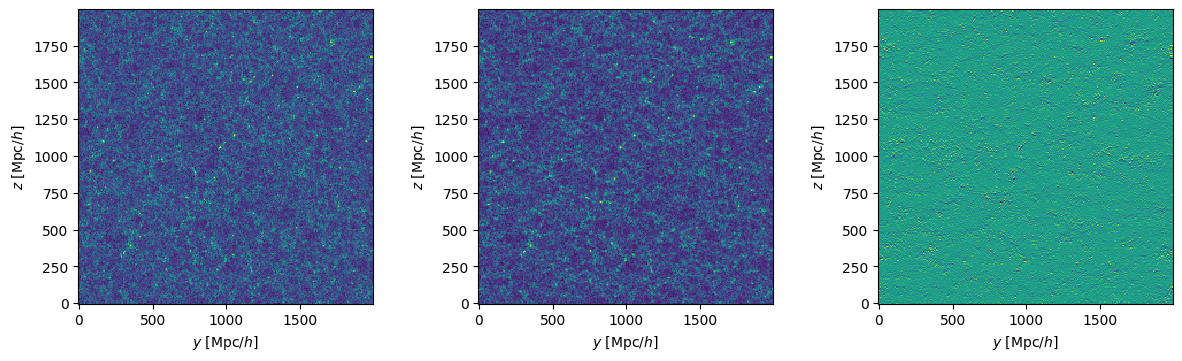

In [ ]:
from montecosmo.plot import plot_mesh
box_size = np.array(3* [2000.])
axis = 0
ids = 0.1
plt.figure(figsize=(12,3.5), layout='constrained')
plt.subplot(131)
plot_mesh(tracer_mesh, box_size=box_size, ids=ids, axis=axis)
plt.subplot(132)
plot_mesh(rsd_mesh, box_size=box_size, ids=ids, axis=axis)
plt.subplot(133)
plot_mesh(tracer_mesh - rsd_mesh, box_size=box_size, ids=ids, axis=axis);

mean: -5.29733e-17, std: 1.18293e+00, mesh p.05-.95: [-1.35933718  2.27480427]
mean: -5.63785e-17, std: 1.05910e+00, mesh p.05-.95: [-1.39253803  1.97300979]
mean: -9.57310e-18, std: 1.07122e+00, mesh p.05-.95: [-1.40097965  1.99704292]
mean: -5.52542e-17, std: 1.05910e+00, mesh p.05-.95: [-1.39254815  1.97258969]


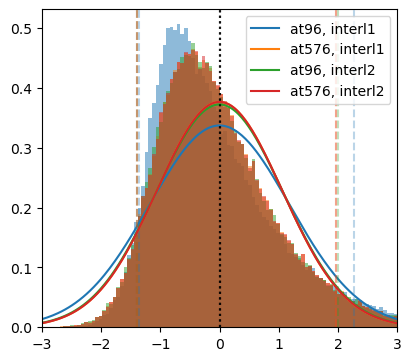

In [ ]:
def plot_pdf(mesh, label, vlim=1e-2):
    # mesh = jnp.log10(1+mesh[mesh>1e-2])
    print(f"mean: {mesh.mean():.5e}, std: {mesh.std():.5e}, mesh p.05-.95: {np.quantile(mesh, [0.05, 0.95])}")
    if vlim is None:
        vlim = mesh.min(), mesh.max()
    elif isinstance(vlim, float):
        vlim = np.quantile(mesh, [vlim/2, 1-vlim/2])

    from scipy.stats import norm
    x = np.linspace(*vlim, 200)
    pdf = norm.pdf(x, loc=mesh.mean(), scale=mesh.std())
    color = plt.gca()._get_lines.get_next_color()
    plt.plot(x, pdf, label=label, color=color)
    plt.hist(jr.choice(jr.key(48), mesh.ravel(), (100000,), replace=False), range=vlim, bins=100, density=True, color=color, alpha=0.5)
    plt.axvline(0., color='k', linestyle=':', alpha=0.5)

    q05, q95 = np.quantile(np.asarray(mesh), [0.05, 0.95])
    plt.axvline(q05, color=color, linestyle='--', alpha=0.3)
    plt.axvline(q95, color=color, linestyle='--', alpha=0.3)
    plt.xlim(vlim)
    plt.legend();

plt.figure(figsize=(4, 3.5), layout="constrained")
# vlim = -10, 10.
vlim = -3, 3.
plot_pdf(tracer_mesh2, "at96, interl1", vlim)
plot_pdf(tracer_mesh, "at576, interl1", vlim)
plot_pdf(tracer_mesh4, "at96, interl2", vlim)
plot_pdf(tracer_mesh3, "at576, interl2", vlim)
# plt.savefig(f"./figs/abacus_matter_pdf_paint{paint_order:d}_deconv{deconv:d}.png")  

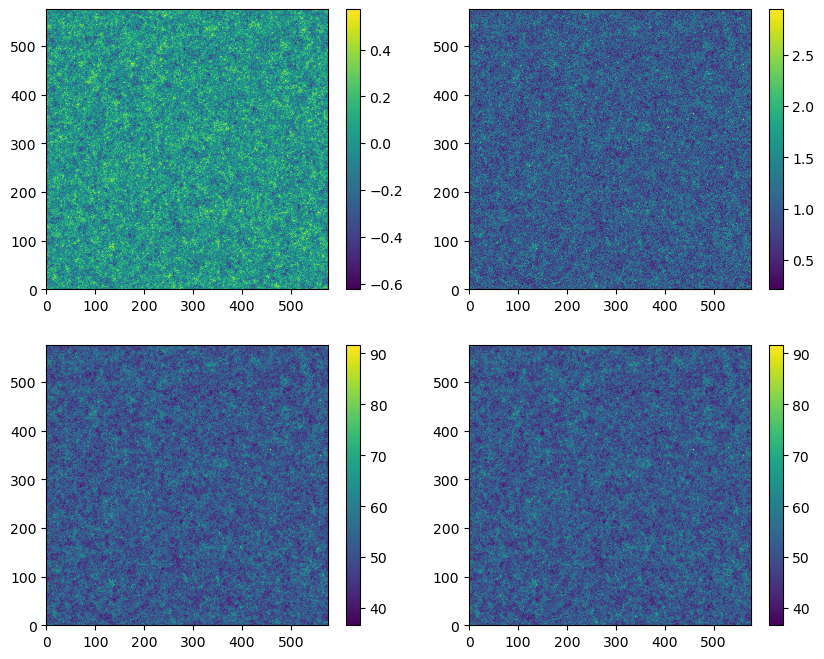

In [ ]:
init_mesh0 = jnp.load(save_dir / f"init_mesh_{mesh_length}.npy")
tracer_mesh0 = jnp.load(save_dir / f"tracer_mesh_6746545_{mesh_length}.npy")
init_paint = jnp.load(save_dir / f"init_paint_{mesh_length}.npy")
fin_paint = jnp.load(save_dir / f"fin_paint_{mesh_length}.npy")
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.pcolormesh(init_mesh0.mean(2))
plt.colorbar()
plt.subplot(222)
plt.pcolormesh(tracer_mesh0.mean(2))
plt.colorbar()
plt.subplot(223)
plt.pcolormesh(fin_paint.mean(2))
plt.colorbar()
plt.subplot(224)
plt.pcolormesh(fin_paint.mean(2))
plt.colorbar()
plt.show()

In [ ]:
import plotly.express as px
idx = np.random.choice(pos.shape[0], size=10000, replace=False)
pos = pos[idx]

fig = px.scatter_3d(
    x=pos[:, 0],
    y=pos[:, 1],
    z=pos[:, 2],
    title="Random Sample of 10,000 Positions"
)
fig.update_traces(marker=dict(size=2))
fig.show()

In [ ]:
from cosmoprimo.fiducial import AbacusSummit
cosmo = AbacusSummit(0)
pk_interpolator = cosmo.get_fourier().pk_interpolator().to_1d(z=0.)

n_interp = 256
ks = jnp.logspace(-4, 1, n_interp)
pows = pk_interpolator(ks) / cosmo.get_fourier().sigma8_m**2
init_kpow = jnp.stack((ks, pows))

np.save(load_dir / f'init_kpow.npy', init_kpow)
print("Omega_m:", cosmo['Omega_m'], "sigma8:", cosmo.get_fourier().sigma8_m)
cosmo.get_params('cosmology')

Omega_m: 0.3151917236644108 sigma8: 0.8076353990239834


{'h': array(0.6736),
 'Omega_cdm': array(0.26447041),
 'Omega_b': array(0.04930169),
 'Omega_k': 0.0,
 'sigma8': 0.8,
 'k_pivot': 0.05,
 'n_s': 0.9649,
 'alpha_s': 0.0,
 'beta_s': 0.0,
 'r': 0.0,
 'n_t': -0.0,
 'alpha_t': -0.0,
 'T_cmb': array(2.7255),
 'm_ncdm': array([0.05999992]),
 'neutrino_hierarchy': None,
 'T_ncdm_over_cmb': array([0.71611]),
 'N_eff': 3.044,
 'tau_reio': 0.0544,
 'reionization_width': 0.5,
 'A_L': 1.0,
 'w0_fld': array(-1.),
 'wa_fld': array(0.),
 'cs2_fld': array(1.),
 'H0': 0.7,
 'omega_cdm': 0.25,
 'Omega_c': 0.25,
 'omega_c': 0.25,
 'Omega_m': 0.25,
 'omega_m': 0.25,
 'Omega0_cdm': 0.25,
 'omch2': 0.25,
 'Omega0_m': 0.25,
 'omega_b': 0.05,
 'Omega0_b': 0.05,
 'ombh2': 0.05,
 'omega_k': 0.0,
 'Omega0_k': 0.0,
 'A_s': array(2.083e-09),
 'logA': 0.8,
 'ln10^10A_s': 0.8,
 'ln10^{10}A_s': 0.8,
 'ln_A_s_1e10': 0.8,
 'ns': 0.96,
 'nrun': 0.0,
 'nrunrun': 0.0,
 'Omega_g': 2.7255,
 'omega_g': 2.7255,
 'T0_cmb': 2.7255,
 'Omega0_g': 2.7255,
 'Omega_ncdm': None,
 'ome

### FPM

In [6]:
path1 = "/pscratch/sd/a/adematti/desi-fnl-standard-analysis/run-knl-fnl-0-a0.5000/catalog_mcut2.25e+12_nbar1.00e-04_los-z.fits"
path2 = "/pscratch/sd/a/adematti/desi-fnl-standard-analysis/run-knl-fnl--100-a0.5000/catalog_mcut2.25e+12_nbar1.00e-04_los-z.fits"
path3 = "/pscratch/sd/a/adematti/desi-fnl-standard-analysis/run-knl-fnl-100-a0.5000/catalog_mcut2.25e+12_nbar1.00e-04_los-z.fits"
assert "fpm" in str(load_dir) and "abacus" not in str(load_dir), "Paths are for AbacusSummit, not for fpm!"

import fitsio
fits = fitsio.read(path1)['Position']
fits.min(), fits.max(), 2*1380

(np.float64(0.0004674247808253984), np.float64(2759.99951171875), 2760)

In [14]:
from montecosmo.nbody import rfftk, deconv_paint, paint, read, interlace, optim_kcut
from montecosmo.utils import ch2rshape, r2chshape, chreshape

# Tracer
import fitsio
paint_length = 576
fin_length = 576
deconv = True
paint_order = 2
los = np.array([0., 0., 1.])
los = los / np.linalg.norm(los)
pos_min, pos_max = 0., 2760.
# a_obs = 1 / (1 + z_obs)
# E = background.Esqr(AbacusSummit0(), a_obs)**.5

fits = fitsio.read(path3)
pos = fits['Position']
np.save(load_dir / f'tracer_pos_{len(pos)}.npy', pos)
# pos = np.load(load_dir / f'tracer_pos_6746545.npy')
print("n_pos:", len(pos), "pos min:", pos.min(0), "pos max:", pos.max(0))

# vel = np.load(load_dir / f'tracer_vel_6746545.npy')
# vel = vel / (a_obs * 100 * E)
# dpos = (vel * los).sum(-1, keepdims=True) * los
# pos += dpos

pos = (pos - pos_min) / (pos_max - pos_min) * paint_length
print("pos min:", pos.min(), "max:", pos.max())

jinterlace = (partial(interlace, paint_order=paint_order, interlace_order=2, 
                        kernel_type='rectangular', oversamp=2., deconv=deconv))
rsd_mesh = jinterlace(pos, 3*(paint_length,))
rsd_mesh *= np.prod(3*(paint_length,)) / len(pos)

rsd_mesh = jnp.fft.irfftn(chreshape(rsd_mesh, r2chshape(3*(fin_length,))))
# rsd_mesh = jnp.fft.irfftn(rsd_mesh)

np.save(load_dir / f'tracer_{len(pos)}_fNL100_paint{paint_order}_deconv{deconv:d}_{fin_length}.npy', rsd_mesh)
# np.save(load_dir / f'tracer_{len(pos)}_rsdflat_paint{paint_order}_deconv{deconv:d}_{fin_length}.npy', rsd_mesh)
print("mesh mean:", rsd_mesh.mean(), "shape:", rsd_mesh.shape)

# tracer_mesh = np.load(load_dir / f'tracer_{len(pos)}_paint{paint_order}_deconv{deconv:d}_{fin_length}.npy')
# ((tracer_mesh - rsd_mesh)**2).mean()

n_pos: 2099376 pos min: [0.00082464 0.00048493 0.00360719] pos max: [2759.99975586 2759.99975586 2759.99983601]
pos min: 0.00010120249758272067 max: 575.9999657758935
mesh mean: 0.9999999999999999 shape: (576, 576, 576)


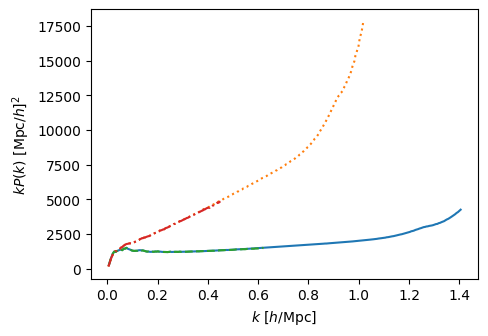

In [13]:
from montecosmo.metrics import spectrum
from montecosmo.plot import plot_pow
mesh1 = np.load("/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z08_lrg/load/tracer_6746545_paint2_deconv1_576.npy")
mesh2 = np.load("/pscratch/sd/h/hsimfroy/png/fpm_b2760_z05_lrg_fNL/load/tracer_2099282_paint2_deconv1_576.npy")
kpow1 = spectrum(mesh1, box_size=3*(2000,))
kpow2 = spectrum(mesh2, box_size=3*(2760,))

mesh3 = np.load("/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z08_lrg/load/tracer_6746545_paint2_deconv1_256.npy")
mesh4 = np.load("/pscratch/sd/h/hsimfroy/png/fpm_b2760_z05_lrg_fNL/load/tracer_2099282_paint2_deconv1_256.npy")
kpow3 = spectrum(mesh3, box_size=3*(2000,))
kpow4 = spectrum(mesh4, box_size=3*(2760,))

plt.figure(figsize=(5,3.5))
plot_pow(*kpow1, label='rsd tracer')
plot_pow(*kpow2, label='flat tracer', ls=':')
plot_pow(*kpow3, label='rsd tracer 256', ls='--')
plot_pow(*kpow4, label='flat tracer 256', ls='-.')

## Validation

### Abacus meshes

In [16]:
from montecosmo.utils import chreshape, r2chshape
def fourier_subsample(mesh0, mesh_length):
    mesh = jnp.fft.rfftn(mesh0)
    mesh = chreshape(mesh, r2chshape(3*(mesh_length,)))
    mesh = jnp.fft.irfftn(mesh)
    return mesh

mesh0 = np.load("/pscratch/sd/h/hsimfroy/png/fpm_b2760_z05_lrg_fNL/load/tracer_2099282_fNL0_paint2_deconv1_576.npy")
# mesh0 = deconv_paint(mesh0, order=2)
mesh_lengths = [256,128,96,64,32]
for m in mesh_lengths:
    tmesh = fourier_subsample(mesh0, m)
    save_path = load_dir / (f"tracer_2099282_fNL0_paint2_deconv1_{m}.npy")
    jnp.save(save_path, tmesh)

mean_576: 1.000
mean_256: 1.000
mean_128: 1.000
mean_64: 1.000
mean_32: 1.000


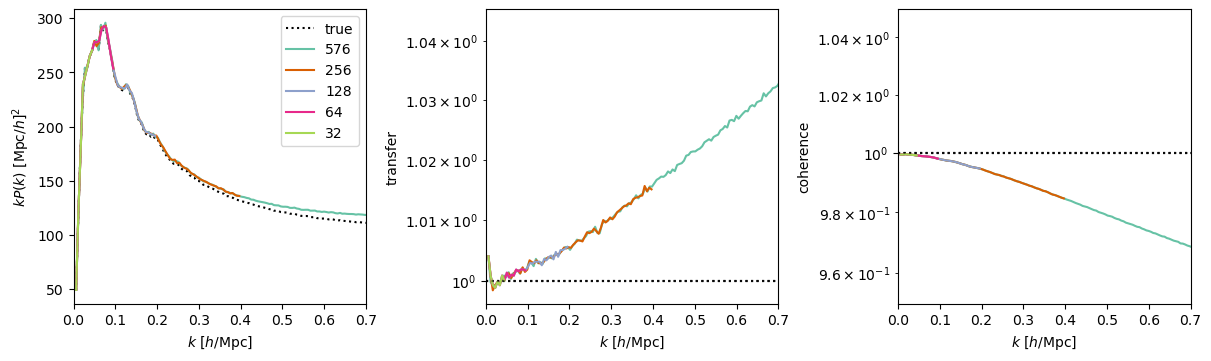

In [ ]:
from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
from montecosmo.metrics import powtranscoh
from montecosmo.metrics import spectrum
from montecosmo.utils import chreshape, r2chshape
from matplotlib import colors
theme(usetex=False)
log = False
cmap = None
mesh_lengths = [576, 256, 128, 64, 32]
xlim = (0, .7)
box_size = np.array(3*(2000,))

def fourier_subsample(mesh0, mesh_length):
    mesh = jnp.fft.rfftn(mesh0)
    mesh = chreshape(mesh, r2chshape(3*(mesh_length,)))
    mesh = jnp.fft.irfftn(mesh)
    return mesh

plt.figure(figsize=(12, 3.5), layout="constrained")

for mesh_length in mesh_lengths:
    mesh0 = jnp.load(load_dir / f"fin_paint2_interl2_deconv1_{mesh_length}.npy")
    # mesh1 = jnp.load(load_dir / f"fin_paint_deconv_{mesh_length}.npy")
    noise = jr.normal(jr.key(45), 3*(576,))
    noise = fourier_subsample(noise, mesh_length)
    mesh1 = mesh0 + 0.5 * noise
    

    # TODO: add noise, that is fourier truncated
    print(f'mean_{mesh_length}: {mesh0.mean():.3f}')

    plt.subplot(131)
    plt.xlim(xlim)
    if mesh_length == mesh_lengths[0]:
        plot_pow(*spectrum(mesh0, box_size=box_size), 'k:', log=log, label="true")
    kptc1 = powtranscoh(mesh0, mesh1, box_size=box_size)
    plot_powtranscoh(*kptc1, log=log, label=mesh_length)
    plt.subplot(131)
    plt.legend()
    plt.subplot(132)
    plt.xlim(xlim)
    plt.axhline(1., linestyle=':', color='k', alpha=0.5)
    plt.subplot(133)
    plt.xlim(xlim)
    plt.ylim(.95,1.05)
    plt.axhline(1., linestyle=':', color='k', alpha=0.5);
# plt.savefig(f"./figs/abacus_matter_pow_interl2_deconv1_noise01.png")

mean_576: 1.000
mean_256: 1.000
mean_128: 1.000
mean_64: 1.000
mean_32: 1.000


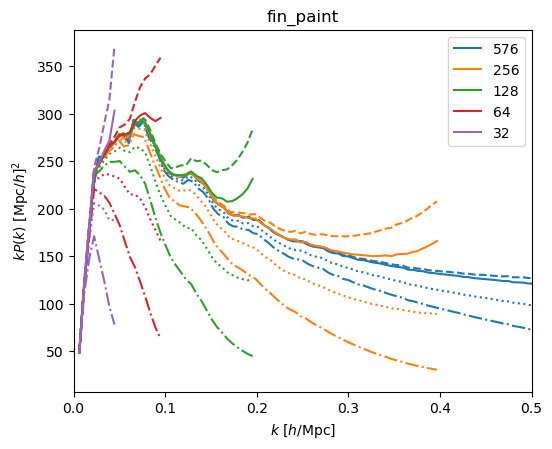

In [ ]:
from montecosmo.plot import plot_mesh, plot_pow, theme
from montecosmo.utils import chreshape, r2chshape
from montecosmo.metrics import spectrum
from montecosmo.bricks import AbacusSummit0
from montecosmo.nbody import deconv_paint
theme(cmap=None)

def fourier_subsample(mesh0, mesh_length):
    mesh = jnp.fft.rfftn(mesh0)
    mesh = chreshape(mesh, r2chshape(3*(mesh_length,)))
    mesh = jnp.fft.irfftn(mesh)
    return mesh

names = ["fin_paint"]
mesh_lengths = [576, 256, 128, 64, 32]
box_size = np.array(3*(2000,))
n_tracers = 6746545
cosmo = AbacusSummit0()
log = False

plt.figure(figsize=(10, 8), layout='constrained')
for i_plot, name in enumerate(names):
    plt.subplot(2,2,i_plot+1)
    plt.title(name)
    plt.xlim(0,0.5)

    if name == "init_mesh":
        init_kpow = jnp.load(load_dir / 'init_kpow.npy')
        init_kpow = (init_kpow[0], init_kpow[1] * cosmo.sigma8**2)
        plot_pow(*init_kpow, 'k+-', log=log, label="theory")

    for m in mesh_lengths:
        color = plt.gca()._get_lines.get_next_color()

        if name == "fin_paint":
            save_path = load_dir / (name + f"2_at_{m}.npy")
            tmesh = jnp.load(save_path)
            tmesh = deconv_paint(tmesh, order=2)
            kpow = spectrum(tmesh, box_size=box_size)
            plot_pow(*kpow, "-", log=log, color=color, label=f"{m}")
            print(f'mean_{m}: {tmesh.mean():.3f}')

            save_path = load_dir / (name + f"1_at_{m}.npy")
            tmesh = jnp.load(save_path)
            tmesh = deconv_paint(tmesh, order=1)
            kpow = spectrum(tmesh, box_size=box_size)
            plot_pow(*kpow, "--", log=log, color=color)

            save_path = load_dir / (name + f"2_at_{m}.npy")
            tmesh = jnp.load(save_path)
            # mesh = deconv_paint(mesh, order=2)
            kpow = spectrum(tmesh, box_size=box_size)
            plot_pow(*kpow, "-.", log=log, color=color)

            save_path = load_dir / (name + f"1_at_{m}.npy")
            tmesh = jnp.load(save_path)
            # mesh = deconv_paint(mesh, order=1)
            kpow = spectrum(tmesh, box_size=box_size)
            plot_pow(*kpow, ":", log=log, color=color)

    plt.legend()
# plt.savefig(f"./figs/abacus_matter_pow_paint12_deconv01.png")      
# plt.show()

mean_576: -0.000
mean_256: -0.000
mean_128: -0.000
mean_64: -0.000
mean_32: -0.000

mean_576: 1.000
mean_256: 1.000
mean_128: 1.000
mean_64: 1.000
mean_32: 1.000

mean_576: 1.000
mean_256: 1.000
mean_128: 1.000
mean_64: 1.000
mean_32: 1.000

mean_576: 1.000
mean_256: 1.000
mean_128: 1.000
mean_64: 1.000
mean_32: 1.000



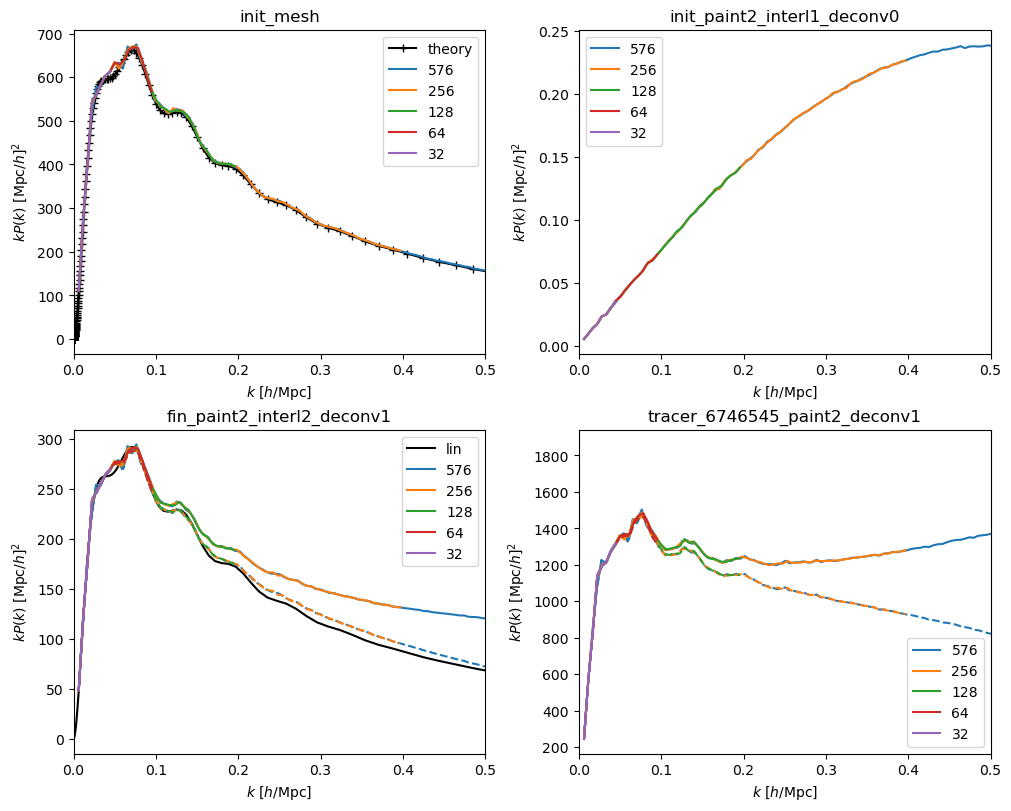

In [ ]:
from montecosmo.plot import plot_mesh, plot_pow, theme
from montecosmo.utils import chreshape, r2chshape
from montecosmo.metrics import spectrum
from montecosmo.bricks import AbacusSummit0
from montecosmo.nbody import deconv_paint, a2g
theme(cmap=None)

def fourier_subsample(mesh0, mesh_length):
    mesh = jnp.fft.rfftn(mesh0)
    mesh = chreshape(mesh, r2chshape(3*(mesh_length,)))
    mesh = jnp.fft.irfftn(mesh)
    return mesh

names = ["init_mesh", "init_paint2_interl1_deconv0", "fin_paint2_interl2_deconv1", "tracer_6746545_paint2_deconv1"]
mesh_lengths = [576,256,128,64,32]
box_size = np.array(3*(2000,))
n_tracers = 6746545
cosmo = AbacusSummit0()
log = False
z_obs = 0.8

plt.figure(figsize=(10, 8), layout='constrained')
for i_plot, name in enumerate(names):
    plt.subplot(2,2,i_plot+1)
    plt.title(name)
    plt.xlim(0,0.5)

    # plot_mesh(mesh0)
    # plt.colorbar()

    if name == "init_mesh":
        init_kpow = jnp.load(load_dir / 'init_kpow.npy')
        init_kpow = (init_kpow[0], init_kpow[1] * cosmo.sigma8**2)
        plot_pow(*init_kpow, 'k+-', log=log, label="theory")

    if name == "fin_paint2_interl2_deconv1":
        init_kpow = jnp.load(load_dir / 'init_kpow.npy')
        init_kpow = (init_kpow[0], init_kpow[1] * cosmo.sigma8**2 * a2g(cosmo, 1/(1+z_obs))**2)
        plot_pow(*init_kpow, 'k-', log=log, label="lin")

    for m in mesh_lengths:
        color = plt.gca()._get_lines.get_next_color()
        save_path = load_dir / (name + f"_{m}.npy")
        tmesh = jnp.load(save_path)
        kpow = spectrum(tmesh, box_size=box_size)
        plot_pow(*kpow, log=log, label=f"{m}", color=color)
        print(f'mean_{m}: {tmesh.mean():.3f}')

        if name == "fin_paint2_interl2_deconv1" or name == "tracer_6746545_paint2_deconv1":
            save_path = load_dir / (name.replace("deconv1", "deconv0") + f"_{m}.npy")
            tmesh = jnp.load(save_path)
            kpow = spectrum(tmesh, box_size=box_size)
            plot_pow(*kpow, "--", log=log, color=color)
    print()
    plt.legend()      
plt.show()

### Forward model

In [2]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload , chreshape, r2chshape, boxreshape
from montecosmo.bricks import top_hat_selection, gen_gauss_selection

box_size = 3*(2760,)
overselect = None
selection = None if overselect is None else overselect + 0.05
mesh_length = 256
# mesh_length = 64
# mesh_length = 96
# mesh_length = 128
z_obs = 0.8

model = FieldLevelModel(**default_config | 
                        {'final_shape': 3*(mesh_length,), 
                        # 'cell_length': box_size[0] / mesh_length, # in Mpc/h
                        'cell_length': (1 if overselect is None else 1+overselect) * box_size[0] / mesh_length, # in Mpc/h
                        # 'box_center': (0.,0.,0.), # in Mpc/h
                        'box_center': (0.,0.,1.), # in Mpc/h
                        # 'box_center': (0.,0.,1938.), # in Mpc/h # a2chi(model.cosmo_fid, a=1/(1+z_obs))
                        # 'box_center': (0.,0.,-1.), # in Mpc/h
                        # 'box_center': (0.,1.,0.), # in Mpc/h

                        'box_rotvec': (0.,0.,0.,), # rotation vector in radians
                        'evolution': 'lpt',
                        # 'evolution': 'kaiser',
                        'a_obs': 1 / (1 + z_obs), # light-cone if None
                        'curved_sky': False, # curved vs. flat sky
                        'ap_auto': None, # parametrized AP vs. auto AP
                        'selection': selection, # if float, padded fraction, if str or Path, path to window mesh file
                        'paint_order':2, # order of interpolation kernel
                        'paint_deconv': True, # whether to deconvolve painted field
                        'kernel_type':'rectangular', # 'rectangular', 'kaiser_bessel'
                        'init_oversamp':1., # initial mesh 1D oversampling factor
                        'evol_oversamp':2., # evolution mesh 1D oversampling factor
                        'ptcl_oversamp':2., # particle cloud 1D oversampling factor
                        'paint_oversamp':2., # painted mesh 1D oversampling factor

                        # 'init_oversamp':1.5, # initial mesh 1D oversampling factor
                        # 'evol_oversamp':1.5, # evolution mesh 1D oversampling factor
                        # 'ptcl_oversamp':1.5, # particle cloud 1D oversampling factor
                        # 'paint_oversamp':1.5, # painted mesh 1D oversampling factor

                        # 'init_oversamp':1., # initial mesh 1D oversampling factor
                        # 'evol_oversamp':1., # evolution mesh 1D oversampling factor
                        # 'ptcl_oversamp':1., # particle cloud 1D oversampling factor
                        # 'paint_oversamp':1., # painted mesh 1D oversampling factor
                        'interlace_order':2, # interlacing order
                        'n_rbins': 1,
                        'k_cut': np.inf,
                        'init_power': load_dir / f'init_kpow.npy',
                        # 'init_power': None,
                        'lik_type': 'gaussian_delta',
                        'png_type': None,
                        } )

truth = {
    'Omega_m': 0.3137721, 
    'sigma8': 0.8076353990239834,
    'b1': 0.,
    'b2': 0.,
    'bs2': 0.,
    
    'b1': 1.15,
    'b2': 0.2,
    'bs2': -0.2,
    'bn2': 0.,
    'bnpar': 0.,
    'fNL': 0.,
    'fNL_bp':0.,
    'fNL_bpd':0.,
    'alpha_iso': 1.,
    'alpha_ap': 1.,
    'ngbars': 8.43318125e-4,
    # 'ngbars': 10000., # neglect lik noise
    'sigma_0': 0.5,
    'sigma_delta': 0.7,
    }

latents = model.new_latents_from_loc(truth)
model = FieldLevelModel(**model.asdict() | {'latents': latents})
print(model)
# model.render()



# # Abacus matter
# # obs_mesh = jnp.load(load_dir / f'fin_paint2_interl2_deconv0_{mesh_length}.npy')
# # obs_mesh = jnp.load(load_dir / f'fin_paint2_interl1_deconv1_{mesh_length}.npy')
# obs_mesh = jnp.load(load_dir / f'fin_paint2_interl2_deconv1_{mesh_length}.npy')
# # obs_mesh = (1 + truth['b1']) * (obs_mesh - 1) + 1
# obs_mesh *= truth['ngbars'] * model.cell_length**3
# # var = truth['sigma_0'] * model.cell_length**3
# # obs_mesh += jr.normal(jr.key(44), obs_mesh.shape) * var**.5
# # # obs_mesh = jr.poisson(jr.key(44), jnp.abs(obs_mesh + 1) * mean_count)

# # Abacus tracer real-space
# obs_mesh = jnp.load(load_dir / f'tracer_6746545_paint2_deconv1_{mesh_length}.npy')
# obs_mesh *= truth['ngbars'] * model.cell_length**3

# # Abacus tracer redshift-space
# obs_mesh = jnp.load(load_dir / f'tracer_6746545_rsdflat_paint2_deconv1_{mesh_length}.npy')
# obs_mesh *= truth['ngbars'] * model.cell_length**3

# # Abacus initial
# init_mesh = jnp.fft.rfftn(jnp.load(load_dir / f'init_mesh_{576}.npy'))
# init_mesh = chreshape(init_mesh, r2chshape(model.init_shape))
# truth0 = truth | {'init_mesh': init_mesh} | {'obs': obs_mesh}
# del obs_mesh
# del init_mesh

# # Abacus within bigger volume 
# # /!\ Don't known init_mesh anymore, load a fake one
# init_mesh = jnp.fft.rfftn(jnp.load(load_dir / f"init_mesh_fake_3000_{256}.npy"))
# init_mesh = chreshape(init_mesh, r2chshape(model.init_shape))

# # obs_mesh = jnp.load(load_dir / f'tracer_6746545_paint2_deconv1_{256}.npy')
# obs_mesh = jnp.load(load_dir / f'tracer_6746545_rsdflat_paint2_deconv1_{256}.npy')
# over_shape = 3*(int((1+overselect) * 256),)
# print(f"{over_shape=}")
# selec_mesh = top_hat_selection(over_shape, model.selection)
# selec_mesh *= top_hat_selection(over_shape, 1., norm_order=4., pow_order=4.)
# # selec_mesh *= gen_gauss_selection(model.box_center, model.box_rot, model.box_size, over_shape, True, order=4.)
# selec_mesh /= selec_mesh[selec_mesh > 0].mean()

# obs_mesh = realreshape(obs_mesh, over_shape)
# obs_mesh *= selec_mesh
# obs_mesh = jnp.fft.rfftn(obs_mesh)
# obs_mesh = jnp.fft.irfftn(chreshape(obs_mesh, r2chshape(model.final_shape)))
# obs_mesh = model.mesh2masked(obs_mesh)
# obs_mesh *= truth['ngbars'] * model.cell_length**3 / obs_mesh.mean()
# truth0 = truth | {'init_mesh': init_mesh} | {'obs': obs_mesh}
# del obs_mesh

# Self-specified
# truth |= {'init_mesh': truth0['init_mesh']}
# truth1 = model.predict(samples=truth, hide_base=False, hide_samp=False, from_base=True)
# truth1 = model.predict(samples=truth, hide_base=False, hide_samp=False, hide_det=False, from_base=True)
# jnp.save(load_dir / f"lpt_ptcl_osamp1.5_2_{mesh_length}", truth1["lpt_ptcl"])
truth1 = model.predict(samples=truth, hide_base=False, from_base=True)
jnp.save(load_dir / f"init_mesh_fake_2760_{mesh_length}", jnp.fft.irfftn(truth1["init_mesh"]))


# model2 = FieldLevelModel(**model.asdict() | {
#                         # 'init_oversamp':1.5, # initial mesh 1D oversampling factor
#                         # 'evol_oversamp':2., # evolution mesh 1D oversampling factor
#                         # 'ptcl_oversamp':2., # particle cloud 1D oversampling factor
#                         # 'paint_oversamp':2., # painted mesh 1D oversampling factor
#                         # 'kernel_type':'kaiser_bessel',
#                         # 'paint_order':4,
#                         'png': True,
#                                                 })
# # coeff = 1.5
# # truth |= {'sigma8': truth0['sigma8'] * coeff, 'b1': (1+truth0['b1']) / coeff - 1}
# # truth |= {'sigma8': truth0['sigma8'] * coeff, 'init_mesh': truth0['init_mesh'] * coeff}
# # init_mesh = jnp.fft.rfftn(jnp.load(load_dir / f'init_mesh_{576}.npy'))
# # init_mesh = chreshape(init_mesh, r2chshape(model2.init_shape))
# # truth |= {'init_mesh': init_mesh}
# truth2 = model2.predict(samples=truth, hide_base=False, hide_samp=False, from_base=True)

# model2 = FieldLevelModel(**model.asdict() | {
#                                                 })
# coeff = 1.5
# # truth |= {'sigma8': truth0['sigma8'] * coeff, 'b1': (1+truth0['b1']) / coeff - 1}
# # truth |= {'sigma8': truth0['sigma8'] * coeff}
# truth |= {'sigma8': truth0['sigma8'] * coeff, 'init_mesh': truth0['init_mesh'] * coeff}
# truth2 = model2.predict(samples=truth, hide_base=False, hide_samp=False, from_base=True)

model.save(save_dir / "model.yaml")    
jnp.savez(save_dir / "truth.npz", **truth)
delta_obs0 = model.count2delta(truth0['obs'])
delta_obs1 = model.count2delta(truth1['obs'])
# delta_obs2 = model2.count2delta(truth2['obs'])
# delta_obs3 = model3.count2delta(truth3['obs'])
# delta_obs1 = truth1['obs'] / model.count_fid - 1
print(f'obs0 mean: {truth0['obs'].mean():.5e}, std: {truth0['obs'].std():.5e}')
print(f'obs1 mean: {truth1['obs'].mean():.5e}, std: {truth1['obs'].std():.5e}')

obs = ['obs','fNL','bnpar',
    #    'b1','b2','bs2','bn2',
       'ngbars', 'sigma_0', 'sigma_delta', 
       'Omega_m',
    #    'sigma8',
    #    'init_mesh',
       'alpha_iso','alpha_ap',]
obs = {k: truth0[k] for k in obs}

# model.substitute(obs, from_base=True)
# model.block()
# # params_start_ = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs0, scale_field=1.)))(jr.split(jr.key(45), n_chains)) 
# params_start_ = model.kaiser_post(jr.key(45), delta_obs0, scale_field=1/5)
# print('start params:', params_start_.keys())
# potential_valgrad = jit(value_and_grad(model.potential))
# # model.render()
# # potential_valgrad(params_start_ | {'sigma8_':0.3})

/global/u1/h/hsimfroy/miniforge3/envs/montenv/lib/python3.14/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


# CONFIG
{'a_obs': 0.5555555555555556,
 'ap_auto': None,
 'box_center': array([0., 0., 1.]),
 'box_rotvec': array([0., 0., 0.]),
 'cell_length': 10.78125,
 'curved_sky': False,
 'evol_oversamp': 2.0,
 'evolution': 'lpt',
 'final_shape': array([256, 256, 256]),
 'init_oversamp': 1.0,
 'init_power': '/pscratch/sd/h/hsimfroy/png/fpm_b2760_z05_lrg_fNL/load/init_kpow.npy',
 'interlace_order': 2,
 'k_cut': inf,
 'kernel_type': 'rectangular',
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3137721,
                         'low': 0.05,
                         'scale': 0.1,
                         'scale_fid': 0.01},
             'alpha_ap': {'group': 'ap',
                          'high': inf,
                          'label': '{\\alpha}_\\mathrm{AP}',
                          'loc': 1.0,
                          'loc_fid': 1.0,


NameError: name 'truth0' is not defined

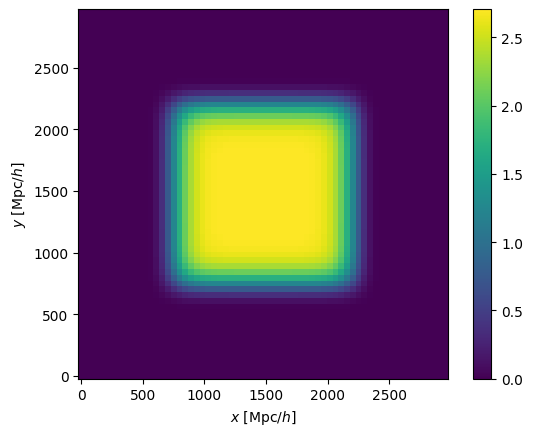

In [15]:
from montecosmo.bricks import top_hat_selection, gen_gauss_selection
from montecosmo.plot import plot_mesh
selec_mesh = top_hat_selection(3*(64,), model.selection)
selec_mesh *= top_hat_selection(3*(64,), 1., norm_order=8., pow_order=8.)
# selec_mesh *= gen_gauss_selection(np.array((0,0,1)), model.box_rot, model.box_size, 3*(64,), True, order=1.)
selec_mesh /= selec_mesh[selec_mesh > 0].mean()

plot_mesh(selec_mesh, model.box_size, ids=0.1, axis=2)
plt.colorbar()

Array(4.86389733, dtype=float64)

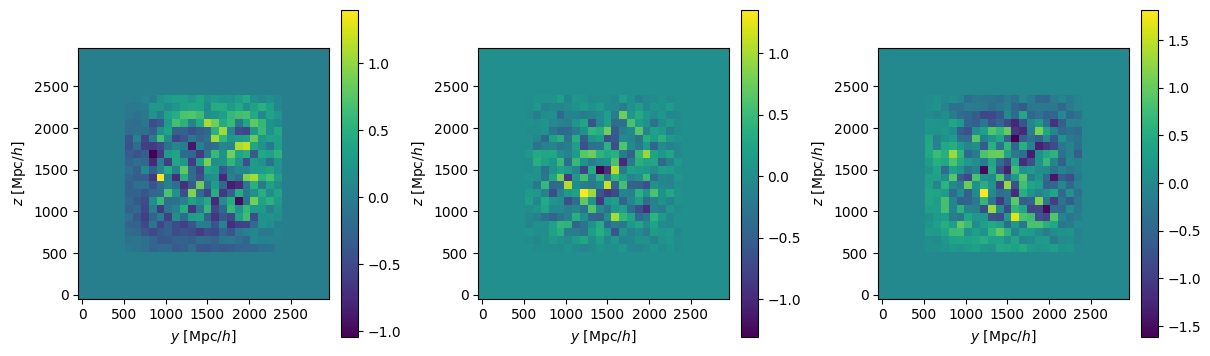

In [62]:
from montecosmo.plot import plot_mesh
plt.figure(figsize=(12, 3.5), layout="constrained")
ids = .1
axis = 0
plt.subplot(131)
plot_mesh(delta_obs0, model.box_size, ids=ids, axis=axis)
plt.colorbar()
plt.subplot(132)
plot_mesh(delta_obs1, model.box_size, ids=ids, axis=axis)
plt.colorbar()
plt.subplot(133)
plot_mesh(delta_obs1-delta_obs0, model.box_size, ids=ids, axis=axis)
plt.colorbar() 

jnp.max(jnp.abs(delta_obs1-delta_obs0))

Array(13.41921472, dtype=float64)

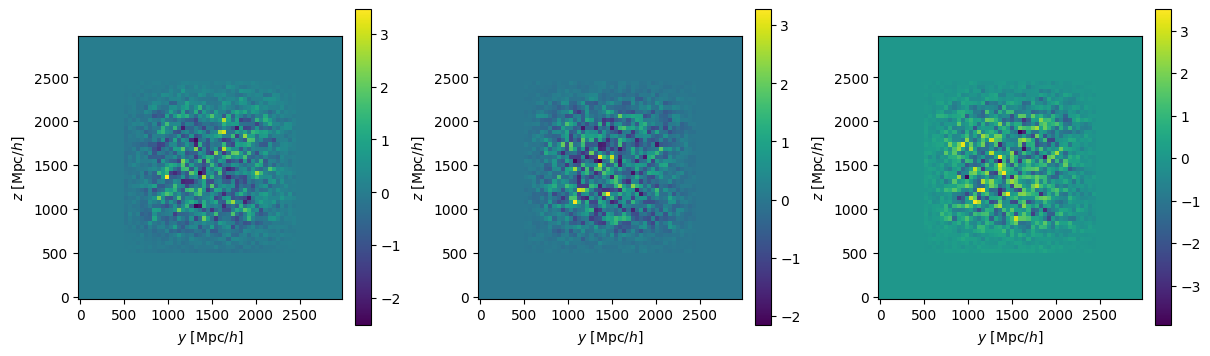

In [40]:
from montecosmo.plot import plot_mesh
plt.figure(figsize=(12, 3.5), layout="constrained")
ids = 0.1
axis = 0
plt.subplot(131)
plot_mesh(delta_obs0, model.box_size, ids=ids, axis=axis)
plt.colorbar()
plt.subplot(132)
plot_mesh(delta_obs1, model.box_size, ids=ids, axis=axis)
plt.colorbar()
plt.subplot(133)
plot_mesh(delta_obs1-delta_obs0, model.box_size, ids=ids, axis=axis)
plt.colorbar() 

jnp.max(jnp.abs(delta_obs1-delta_obs0))

Array(7.72155023, dtype=float64)

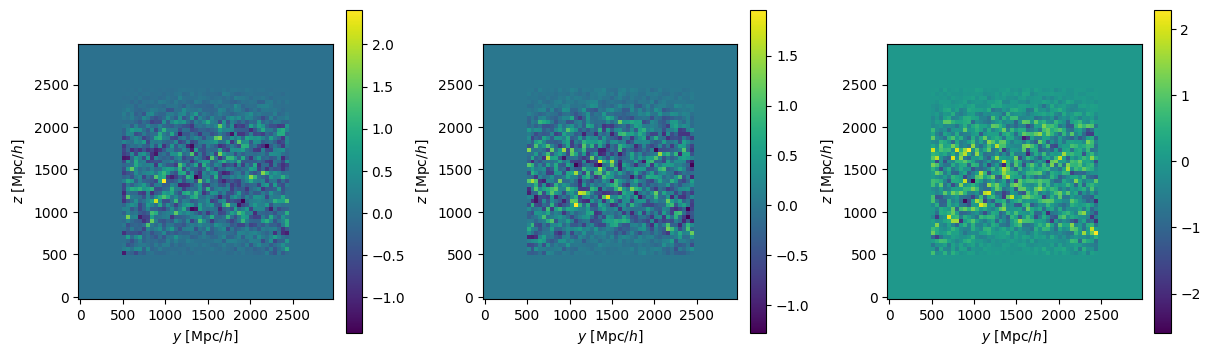

In [12]:
from montecosmo.plot import plot_mesh
plt.figure(figsize=(12, 3.5), layout="constrained")
ids = 0.1
axis = 0
plt.subplot(131)
plot_mesh(delta_obs0, model.box_size, ids=ids, axis=axis)
plt.colorbar()
plt.subplot(132)
plot_mesh(delta_obs1, model.box_size, ids=ids, axis=axis)
plt.colorbar()
plt.subplot(133)
plot_mesh(delta_obs1-delta_obs0, model.box_size, ids=ids, axis=axis)
plt.colorbar() 

jnp.max(jnp.abs(delta_obs1-delta_obs0))

Array(3.29326548, dtype=float64)

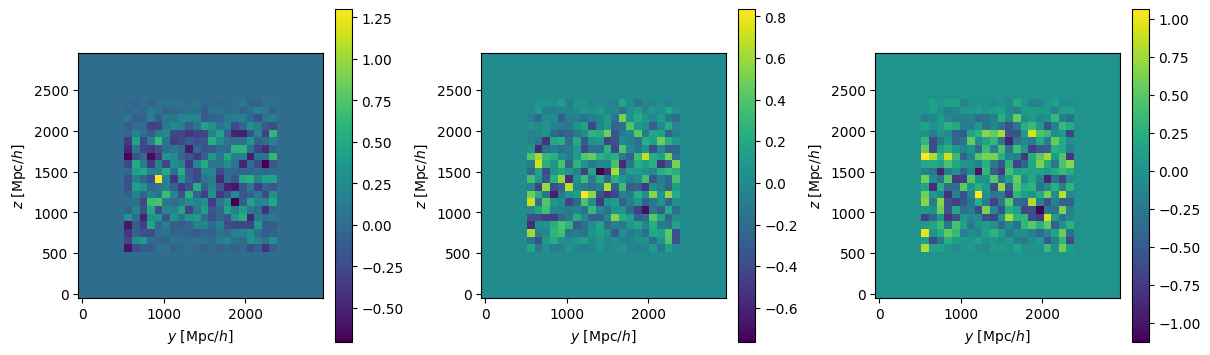

In [ ]:
from montecosmo.plot import plot_mesh
plt.figure(figsize=(12, 3.5), layout="constrained")
ids = 0.1
axis = 0
plt.subplot(131)
plot_mesh(delta_obs0, model.box_size, ids=ids, axis=axis)
plt.colorbar()
plt.subplot(132)
plot_mesh(delta_obs1, model.box_size, ids=ids, axis=axis)
plt.colorbar()
plt.subplot(133)
plot_mesh(delta_obs1-delta_obs0, model.box_size, ids=ids, axis=axis)
plt.colorbar() 

jnp.max(jnp.abs(delta_obs1-delta_obs0))

Array(3.95888702, dtype=float64)

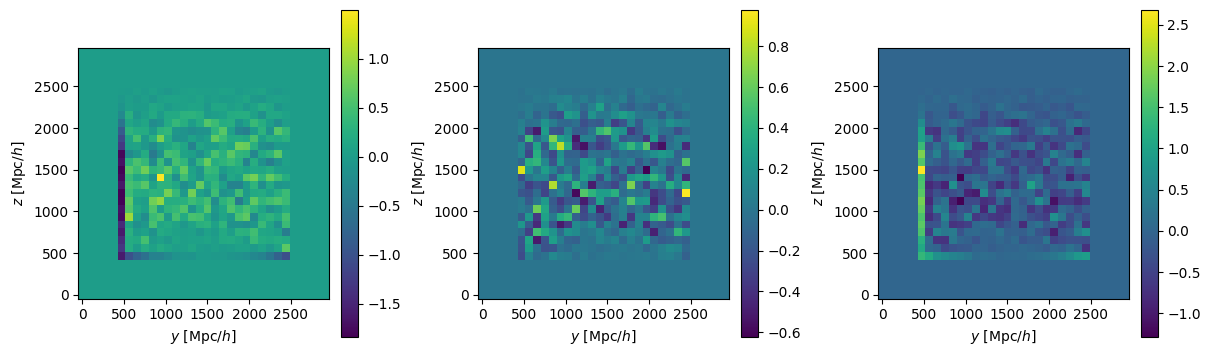

In [ ]:
from montecosmo.plot import plot_mesh
plt.figure(figsize=(12, 3.5), layout="constrained")
ids = 0.1
axis = 0
plt.subplot(131)
plot_mesh(delta_obs0, model.box_size, ids=ids, axis=axis)
plt.colorbar()
plt.subplot(132)
plot_mesh(delta_obs1, model.box_size, ids=ids, axis=axis)
plt.colorbar()
plt.subplot(133)
plot_mesh(delta_obs1-delta_obs0, model.box_size, ids=ids, axis=axis)
plt.colorbar() 

jnp.max(jnp.abs(delta_obs1-delta_obs0))

Array(3.47045035, dtype=float64)

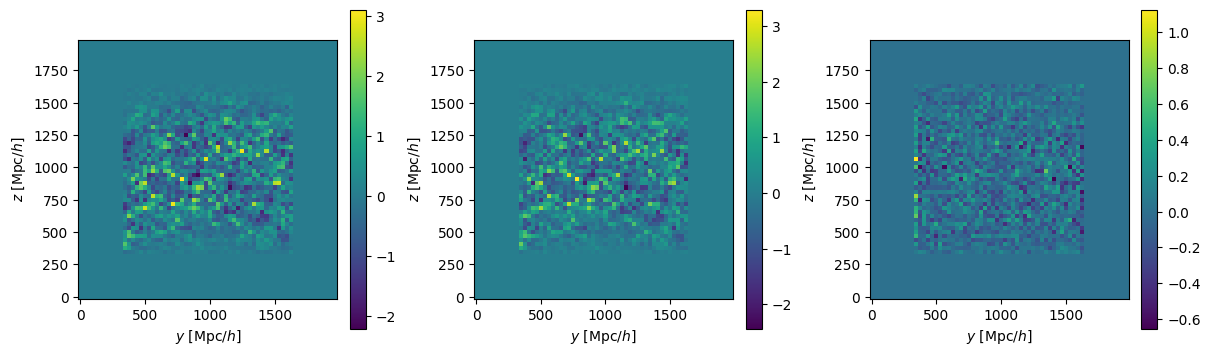

In [ ]:
from montecosmo.plot import plot_mesh
plt.figure(figsize=(12, 3.5), layout="constrained")
ids = 0.1
axis = 0
plt.subplot(131)
plot_mesh(delta_obs0, model.box_size, ids=ids, axis=axis)
plt.colorbar()
plt.subplot(132)
plot_mesh(delta_obs1, model.box_size, ids=ids, axis=axis)
plt.colorbar()
plt.subplot(133)
plot_mesh(delta_obs1-delta_obs0, model.box_size, ids=ids, axis=axis)
plt.colorbar() 

jnp.max(jnp.abs(delta_obs1-delta_obs0))

Array(1.33226763e-15, dtype=float64)

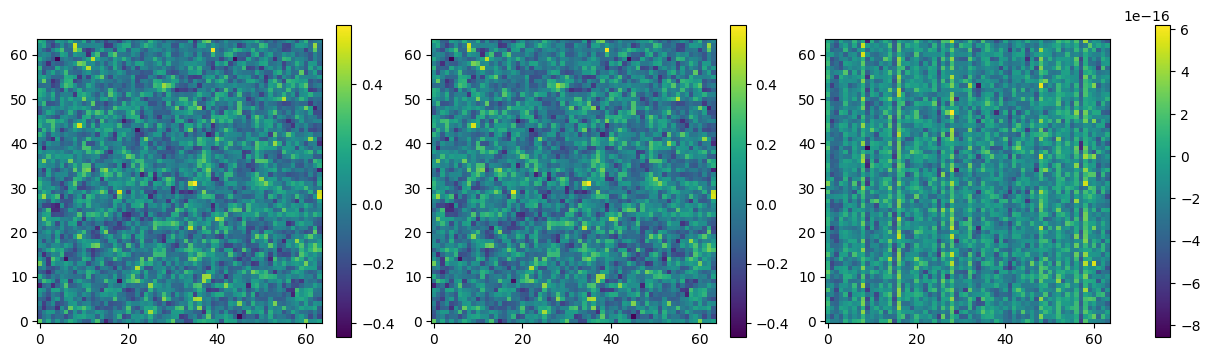

In [ ]:
# Look this commute!
obs_mesh = jnp.load(load_dir / f'fin_paint2_interl2_deconv1_at{576}.npy')
obs_mesh2 = jnp.fft.rfftn(obs_mesh / obs_mesh.mean() - 1)
obs_mesh2 = jnp.fft.irfftn(chreshape(obs_mesh2, r2chshape(model.final_shape)))

obs_mesh3 = jnp.fft.rfftn(obs_mesh)
obs_mesh3 = jnp.fft.irfftn(chreshape(obs_mesh3, r2chshape(model.final_shape)))
obs_mesh3 = obs_mesh3 / obs_mesh3.mean() - 1

from montecosmo.plot import plot_mesh
plt.figure(figsize=(12, 3.5), layout="constrained")
ids = 0.1
plt.subplot(131)
plot_mesh(obs_mesh2, ids=ids)
plt.colorbar()
plt.subplot(132)
plot_mesh(obs_mesh3, ids=ids)
plt.colorbar()
plt.subplot(133)
plot_mesh(obs_mesh3-obs_mesh2, ids=ids)
plt.colorbar() 

jnp.max(jnp.abs(obs_mesh3-obs_mesh2))

### Real-space degeneracy

In [ ]:
from montecosmo.chains import Chains
from montecosmo.plot import SetDark2
from getdist import plots
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload , Path


model = FieldLevelModel.load("/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z08_lrg/tracer_real_eh0_ovsamp1_s8biases/lpt_64/model.yaml")
chains = pload("/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z08_lrg/tracer_real_eh0_ovsamp1_s8_b1prior/lpt_64_eevpd_too_high/test_chains.p")
names = ['sigma8', 'b1', 'b2']
# names = list(model.groups)+['~init_mesh']
gdsamp = chains.prune()[names].to_getdist()


def b1_L2E(b1, inv=False):
    if not inv:
        b1 = 1 + b1
    else:
        b1 = b1 - 1
    return b1

def b2_L2E(b2, b1L, inv=False):
    if not inv:
        b2 = b2 + 8 / 21 * b1L
    else:
        b2 = b2 - 8 / 21 * b1L
    return b2

def reparam_b1(model, b1, sigma8, eulerian=False, inv=False):
    alpha = sigma8 / model.loc_fid['sigma8']

    if not eulerian:
        b1 = b1_L2E(b1)
    if inv:
        b1 *= alpha
    else:
        b1 /= alpha
    if not eulerian:
        b1 = b1_L2E(b1, inv=True)
    return b1

def reparam_b2(model, b2, b1L, sigma8, eulerian=False, inv=False):
    alpha = sigma8 / model.loc_fid['sigma8']

    if not eulerian:
        b2 = b2_L2E(b2, b1L)
    if inv:
        b2 *= alpha**2
    else:
        b2 /= alpha**2
    if not eulerian:
        b2 = b2_L2E(b2, b1L, inv=True)
    return b2

def reparam_bias(self, params:dict, eulerian=False, inv=False):
    """
    Transform sigma8-scaled bias parameters into unscaled bias parameters.
    Consequently, params must contain 'sigma8' key.
    """
    params = params.copy()
    sigma8 = params['sigma8']
    if 'b1' in params:
        b1_ = params['b1']
        b1 = self.reparam_b1(b1_, sigma8, eulerian=eulerian, inv=inv)
        params['b1'] = b1
        if 'b2' in params:
            b1u = b1_ if inv else b1 # unscaled b1
            b1L = b1_L2E(b1u, inv=True) if eulerian else b1u # unscaled b1L
            params['b2'] = self.reparam_b2(params['b2'], b1L, sigma8, eulerian=eulerian, inv=inv)
    return params

chains2 = model.reparam_bias(chains, inv=True)

# chains2 = chains.copy()
# chains2['b1'] = b1_L2E(chains['b1'])
# chains2['b2'] = b2_L2E(chains['b2'], chains['b1'])
# chains2 = model.reparam_bias(chains2, eulerian=True, inv=True)

# chains2 = chains.copy()
# chains2['b1'] = reparam_b1(model, chains['b1'], chains['sigma8'], inv=True)
# chains2['b2'] = reparam_b2(model, chains['b2'], chains['b1'], chains['sigma8'], inv=True)
# chains2['b1'], chains2['b2'] = reparam_bias(model, chains['b1'], chains['b2'], chains['sigma8'], inv=True)

# chains2 |= {k:(1+v) * (chains['sigma8'] / model.loc_fid['sigma8']) - 1 for k,v in chains.items() if k in ['b1']}
# chains2 |= {k:(v + 8 / 21 * chains['b1']) * (chains['sigma8'] / model.loc_fid['sigma8'])**2 - 8 / 21 * chains['b1'] for k,v in chains.items() if k in ['b2']}

# chains2 |= {k:(1+v) * (chains['sigma8'] / model.loc_fid['sigma8']) for k,v in chains.items() if k in ['b1']}
# chains2 |= {k:(v + 8 / 21 * chains['b1']) * (chains['sigma8'] / model.loc_fid['sigma8'])**2 for k,v in chains.items() if k in ['b2']}

# chains2 |= {k:v / chains['b1'] for k,v in chains.items() if k in ['sigma8']}
gdsamp2 = chains2.prune()[names].to_getdist()

chains3 = pload("/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z08_lrg/tracer_real_eh0_ovsamp1_s8biases/lpt_64/test_chains.p")
# chains3 = chains | {k:v * model.loc_fid['sigma8'] / chains['sigma8'] for k,v in chains.items() if k in ['b1','b2','bs2','bn2']}
gdsamp3 = chains3.prune()[names].to_getdist()

Removed no burn in
Removed no burn in
Removed no burn in


In [ ]:
chains2 = model.reparam_bias(chains, eulerian=True, inv=True)
chains2 = model.reparam_bias(chains2, eulerian=True, inv=False)
tree.map(lambda x,y: jnp.allclose(x,y), chains, chains2).prune()[['bias']]

Chains(data={'b1': Array(True, dtype=bool), 'b2': Array(True, dtype=bool), 'bn2': Array(True, dtype=bool), 'bs2': Array(True, dtype=bool)}, groups={'cosmo': ['sigma8'], 'ap': [], 'bias': ['b1', 'b2', 'bn2', 'bs2'], 'init': ['init_mesh'], 'syst': ['ngbars', 'sigma_0', 'sigma_delta'], 'cosmo_': [], 'ap_': [], 'bias_': [], 'init_': [], 'syst_': []}, labels={'Omega_m': '{\\Omega}_m', 'Omega_m_': '\\tilde{\\Omega}_m', 'alpha_ap': '{\\alpha_\\mathrm{AP}}', 'alpha_ap_': '\\tilde{\\alpha_\\mathrm{AP}}', 'alpha_iso': '{\\alpha_\\mathrm{iso}}', 'alpha_iso_': '\\tilde{\\alpha_\\mathrm{iso}}', 'b1': '{b}_1', 'b1_': '\\tilde{b}_1', 'b2': '{b}_2', 'b2_': '\\tilde{b}_2', 'bn2': '{b}_{\\nabla^2}', 'bn2_': '\\tilde{b}_{\\nabla^2}', 'bnp': '{b}_{\\nabla_\\parallel}', 'bnp_': '\\tilde{b}_{\\nabla_\\parallel}', 'bs2': '{b}_{s^2}', 'bs2_': '\\tilde{b}_{s^2}', 'fNL': '{f}_\\mathrm{NL}', 'fNL_': '\\tilde{f}_\\mathrm{NL}', 'init_mesh': '{\\delta_\\mathrm{L}}', 'init_mesh_': '\\tilde{\\delta_\\mathrm{L}}', 'ng

In [ ]:
chains2 = model.reparam_bias(chains, eulerian=False, inv=False)
chains2 = model.reparam_bias(chains2, eulerian=False, inv=True)
tree.map(lambda x,y: jnp.allclose(x,y), chains, chains2).prune()[['bias']]

Chains(data={'b1': Array(True, dtype=bool), 'b2': Array(True, dtype=bool), 'bn2': Array(True, dtype=bool), 'bs2': Array(True, dtype=bool)}, groups={'cosmo': ['sigma8'], 'ap': [], 'bias': ['b1', 'b2', 'bn2', 'bs2'], 'init': ['init_mesh'], 'syst': ['ngbars', 'sigma_0', 'sigma_delta'], 'cosmo_': [], 'ap_': [], 'bias_': [], 'init_': [], 'syst_': []}, labels={'Omega_m': '{\\Omega}_m', 'Omega_m_': '\\tilde{\\Omega}_m', 'alpha_ap': '{\\alpha_\\mathrm{AP}}', 'alpha_ap_': '\\tilde{\\alpha_\\mathrm{AP}}', 'alpha_iso': '{\\alpha_\\mathrm{iso}}', 'alpha_iso_': '\\tilde{\\alpha_\\mathrm{iso}}', 'b1': '{b}_1', 'b1_': '\\tilde{b}_1', 'b2': '{b}_2', 'b2_': '\\tilde{b}_2', 'bn2': '{b}_{\\nabla^2}', 'bn2_': '\\tilde{b}_{\\nabla^2}', 'bnp': '{b}_{\\nabla_\\parallel}', 'bnp_': '\\tilde{b}_{\\nabla_\\parallel}', 'bs2': '{b}_{s^2}', 'bs2_': '\\tilde{b}_{s^2}', 'fNL': '{f}_\\mathrm{NL}', 'fNL_': '\\tilde{f}_\\mathrm{NL}', 'init_mesh': '{\\delta_\\mathrm{L}}', 'init_mesh_': '\\tilde{\\delta_\\mathrm{L}}', 'ng

In [ ]:
b1s = reparam_b1(model, chains['b1'], chains['sigma8'], inv=True)
b1s = reparam_b1(model, b1s, chains['sigma8'], inv=False)

b2s = reparam_b2(model, chains['b2'], chains['b1'], chains['sigma8'], inv=True)
b2s = reparam_b2(model, b2s, b1s, chains['sigma8'], inv=False)
chains['b1'] - b1s, chains['b2'] - b2s

(Array([[ 0.00000000e+00,  0.00000000e+00,  4.44089210e-16, ...,
         -2.22044605e-16, -2.22044605e-16,  0.00000000e+00],
        [ 4.44089210e-16,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -4.44089210e-16,  0.00000000e+00, ...,
          0.00000000e+00, -2.22044605e-16,  2.22044605e-16],
        [ 0.00000000e+00, -2.22044605e-16,  4.44089210e-16, ...,
          0.00000000e+00, -4.44089210e-16,  0.00000000e+00]],      dtype=float64),
 Array([[ 0.00000000e+00, -1.11022302e-16,  0.00000000e+00, ...,
         -1.11022302e-16, -1.11022302e-16,  0.00000000e+00],
        [ 1.11022302e-16,  0.00000000e+00, -1.11022302e-16, ...,
         -1.11022302e-16,  0.00000000e+00,  0.00000000e+00],
        [ 1.11022302e-16, -1.11022302e-16, -1.11022302e-16, ...,
         -1.11022302e-16, -1.11022302e-16,  0.00000000e+00],
        [ 0.00000000e+00, -1.11022302e-16,  2.22044605e-16, ...,
          1.11022302e-16, -1.11

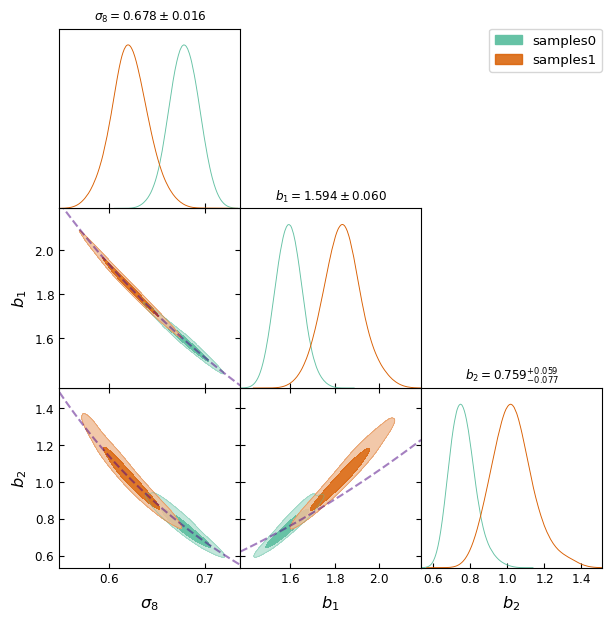

In [ ]:
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp, gdsamp3],
                title_limit=1,
                filled=True, 
                # markers=truth,
                contour_colors=[SetDark2(k) for k in range(10)],)
# Add degeneracy lines
ax = gdplt.get_axes(ax=(1,0))
xs = np.linspace(*ax.get_xlim())
cst1 = (1 + chains['b1'].mean()) * chains['sigma8'].mean()
ax.plot(xs, cst1 / xs - 1, 'indigo', linestyle='--', alpha=0.5)

ax = gdplt.get_axes(ax=(2,0))
xs = np.linspace(*ax.get_xlim())
cst2 = (chains['b1'].mean() * 8 / 21 + chains['b2'].mean()) * chains['sigma8'].mean()**2
ax.plot(xs, cst2 / xs**2 - chains['b1'].mean() * 8 /21, 'indigo', linestyle='--', alpha=0.5)

ax = gdplt.get_axes(ax=(2,1))
xs = np.linspace(*ax.get_xlim())
ax.plot(xs, cst2 / cst1**2 * (1 + xs)**2 - xs * 8 /21, 'indigo', linestyle='--', alpha=0.5)
# plt.show()

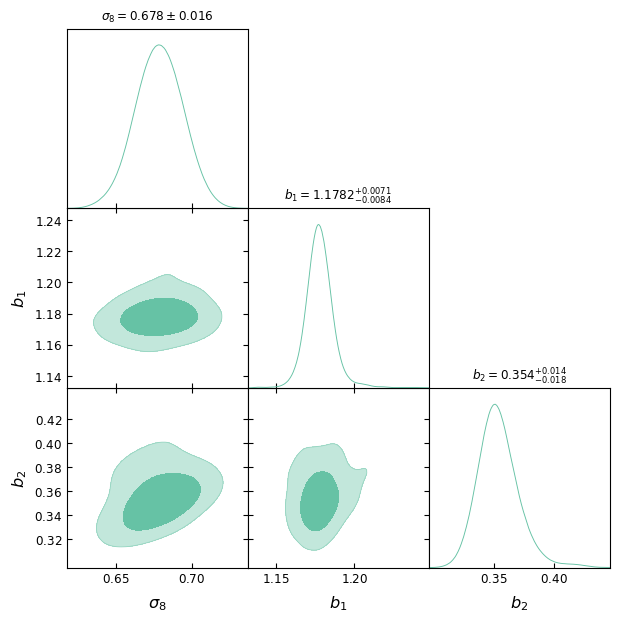

In [ ]:
gdplt = plots.get_subplot_plotter(width_inch=7) # sigma8-scaled lagrangian
gdplt.triangle_plot(roots=[gdsamp2],
                title_limit=1,
                filled=True, 
                # markers=truth,
                contour_colors=[SetDark2(k) for k in range(10)],)
plt.show()

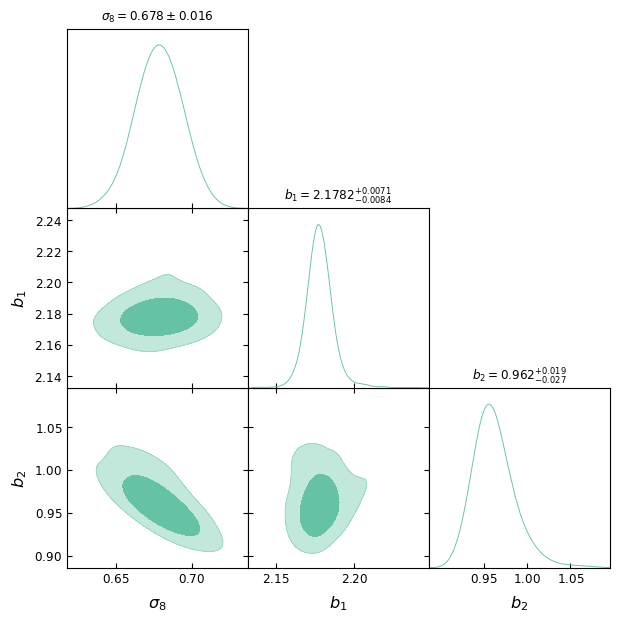

In [ ]:
gdplt = plots.get_subplot_plotter(width_inch=7) # sigma8-scaled eulerian 
gdplt.triangle_plot(roots=[gdsamp2],
                title_limit=1,
                filled=True, 
                # markers=truth,
                contour_colors=[SetDark2(k) for k in range(10)],)
plt.show()

In [ ]:
import plotly.graph_objects as go

chains = pload("/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z08_lrg/tracer_real_eh0_ovsamp1_s8biases/lpt_64/test_chains.p")
names = ['sigma8', 'b1', 'b2']
chains = tree.map(jnp.concatenate, chains[names]).data
from scipy.stats import gaussian_kde
from plotly.graph_objects import Figure

# Extract the samples and flatten
samples = jnp.stack([chains[k] for k in names], -1)
kde = gaussian_kde(samples.T)

# Create evaluation grid
ranges = {k: (chains[k].min(), chains[k].max()) for k in names}
grids = [jnp.linspace(ranges[k][0], ranges[k][1], 30) for k in names]
mesh = jnp.meshgrid(*grids, indexing='ij')
points = jnp.stack([m.ravel() for m in mesh], axis=-1)

# Evaluate KDE
density = kde.logpdf(points.T).reshape(mesh[0].shape)

# Create 3D volume plot
fig = go.Figure()
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    legend=dict(xanchor="right", x=0.99, yanchor="top", y=0.9,),
    # width=800, height=800,
    scene=dict(xaxis_title=names[0], yaxis_title=names[1], zaxis_title=names[2]),
    )


fig.add_scatter3d(x=samples[:,0], 
                  y=samples[:,1], 
                  z=samples[:,2], 
                  mode = 'markers',
                  marker=dict(size=5, symbol='cross'), 
                  name='samples')


fig.add_scatter3d(x=samples[:,0], 
                  y=samples[:,1], 
                  z=samples[:,2], 
                  mode = 'lines',
                  marker=dict(size=5, symbol='cross'), 
                  name='samples')

fig.add_volume(
    x=mesh[0].ravel(),
    y=mesh[1].ravel(),
    z=mesh[2].ravel(),
    value=density.ravel(),
    opacity=.1,
    surface_count=3,
    isomin=np.quantile(density, 0.9),
    isomax=np.quantile(density, 1.),
    colorscale='Viridis'
)
fig.show()


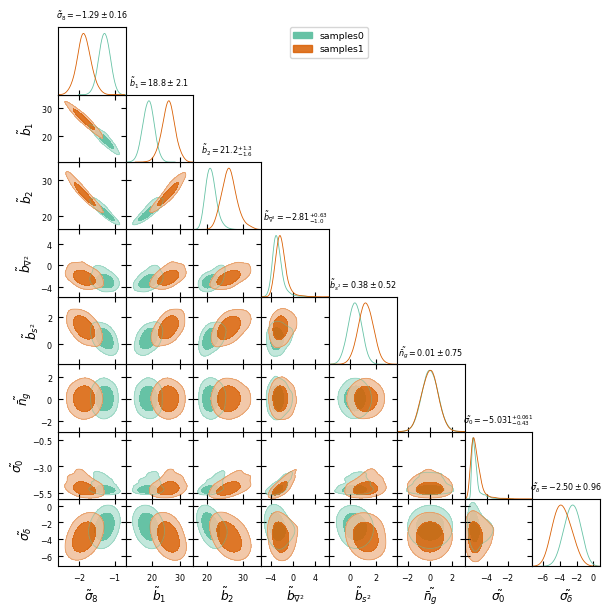

In [ ]:
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp2, gdsamp3],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(k) for k in range(10)],)
plt.show()

### Plot forward model

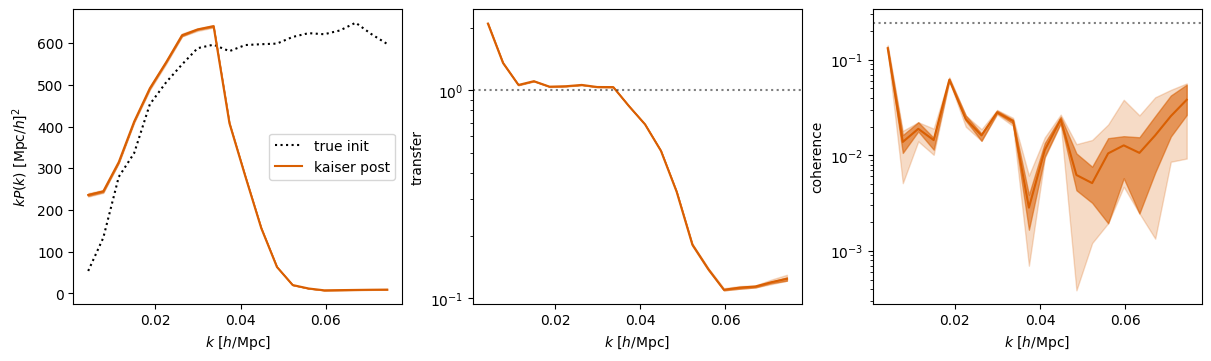

In [27]:
delta_init0 = jnp.fft.irfftn(truth0['init_mesh'])
delta_init1 = jnp.fft.irfftn(truth1['init_mesh'])
params_start_ = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs0, scale_field=1.)))(jr.split(jr.key(45), 20)) 
delta_init2 = vmap(lambda x: jnp.fft.irfftn(model.reparam(x)['init_mesh']))(params_start_)

from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
theme(usetex=False)
log = False

plt.figure(figsize=(12, 3.5), layout="constrained")
plt.subplot(131)
plot_pow(*model.spectrum(delta_init0), 'k:', log=log, label="true init")
# kptc1 = model.powtranscoh(delta_init0, delta_init1)
# plot_powtranscoh(*kptc1, log=log, label="prior")
# kptc2 = model.powtranscoh(delta_init0, delta_init2)
kptc2 = vmap(lambda x: model.powtranscoh(delta_init0, x))(delta_init2)
color = 'C1'
plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptc2), log=log, color=color, label="kaiser post")
plot_powtranscoh(*kptc2, log=log, fill=(0.68,0.95), color=color)
plt.subplot(131)
plt.legend()
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_kptc.png")

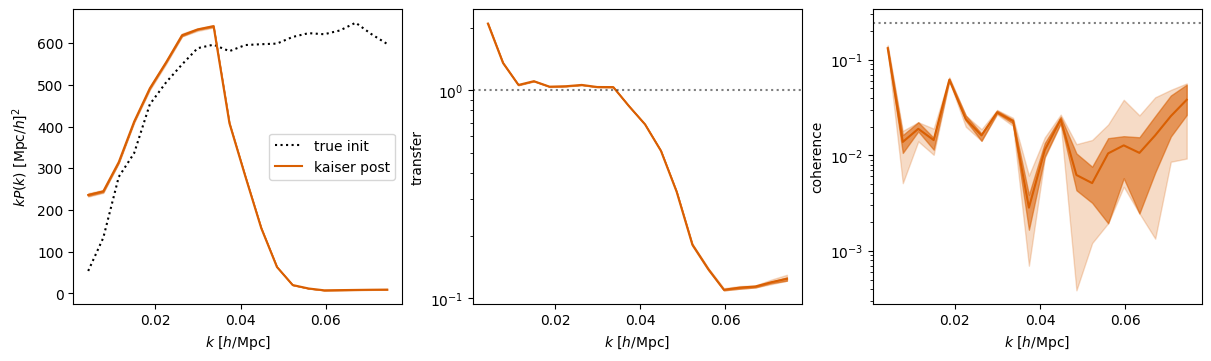

In [ ]:
delta_init0 = jnp.fft.irfftn(truth0['init_mesh'])
delta_init1 = jnp.fft.irfftn(truth1['init_mesh'])
params_start_ = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs0, scale_field=1.)))(jr.split(jr.key(45), 20)) 
delta_init2 = vmap(lambda x: jnp.fft.irfftn(model.reparam(x)['init_mesh']))(params_start_)

from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
theme(usetex=False)
log = False

plt.figure(figsize=(12, 3.5), layout="constrained")
plt.subplot(131)
plot_pow(*model.spectrum(delta_init0), 'k:', log=log, label="true init")
# kptc1 = model.powtranscoh(delta_init0, delta_init1)
# plot_powtranscoh(*kptc1, log=log, label="prior")
# kptc2 = model.powtranscoh(delta_init0, delta_init2)
kptc2 = vmap(lambda x: model.powtranscoh(delta_init0, x))(delta_init2)
color = 'C1'
plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptc2), log=log, color=color, label="kaiser post")
plot_powtranscoh(*kptc2, log=log, fill=(0.68,0.95), color=color)
plt.subplot(131)
plt.legend()
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_kptc.png")

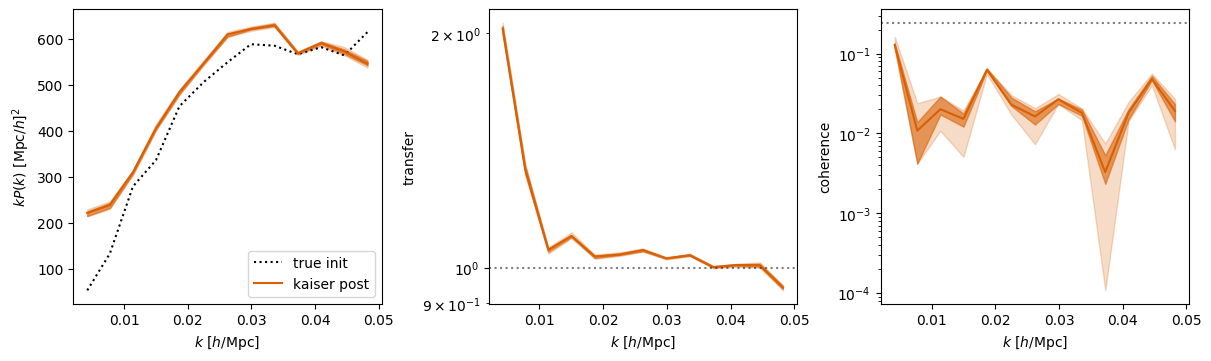

In [17]:
delta_init0 = jnp.fft.irfftn(truth0['init_mesh'])
delta_init1 = jnp.fft.irfftn(truth1['init_mesh'])
params_start_ = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs0, scale_field=1.)))(jr.split(jr.key(45), 20)) 
delta_init2 = vmap(lambda x: jnp.fft.irfftn(model.reparam(x)['init_mesh']))(params_start_)

from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
theme(usetex=False)
log = False

plt.figure(figsize=(12, 3.5), layout="constrained")
plt.subplot(131)
plot_pow(*model.spectrum(delta_init0), 'k:', log=log, label="true init")
# kptc1 = model.powtranscoh(delta_init0, delta_init1)
# plot_powtranscoh(*kptc1, log=log, label="prior")
# kptc2 = model.powtranscoh(delta_init0, delta_init2)
kptc2 = vmap(lambda x: model.powtranscoh(delta_init0, x))(delta_init2)
color = 'C1'
plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptc2), log=log, color=color, label="kaiser post")
plot_powtranscoh(*kptc2, log=log, fill=(0.68,0.95), color=color)
plt.subplot(131)
plt.legend()
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_kptc.png")

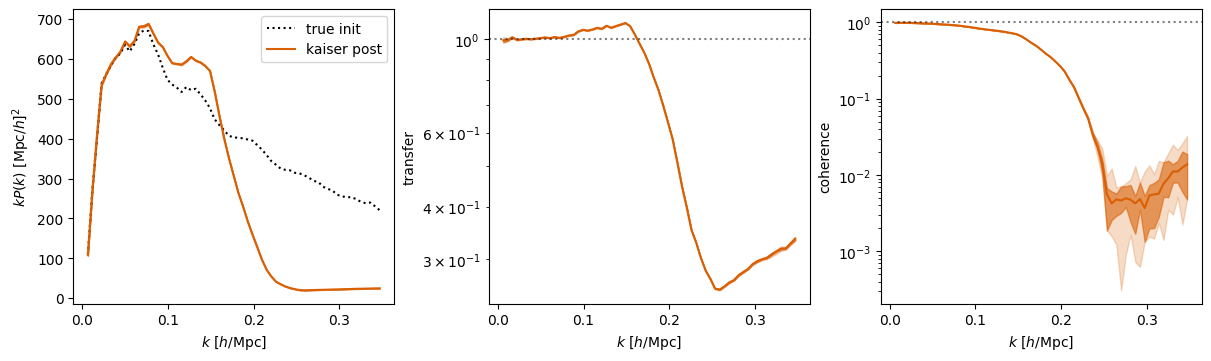

In [ ]:
delta_init0 = jnp.fft.irfftn(truth0['init_mesh'])
delta_init1 = jnp.fft.irfftn(truth1['init_mesh'])
params_start_ = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs1, scale_field=1.)))(jr.split(jr.key(45), 20)) 
delta_init2 = vmap(lambda x: jnp.fft.irfftn(model.reparam(x)['init_mesh']))(params_start_)

from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
theme(usetex=False)
log = False

plt.figure(figsize=(12, 3.5), layout="constrained")
plt.subplot(131)
plot_pow(*model.spectrum(delta_init0), 'k:', log=log, label="true init")
# kptc1 = model.powtranscoh(delta_init0, delta_init1)
# plot_powtranscoh(*kptc1, log=log, label="prior")
# kptc2 = model.powtranscoh(delta_init0, delta_init2)
kptc2 = vmap(lambda x: model.powtranscoh(delta_init0, x))(delta_init2)
color = 'C1'
plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptc2), log=log, color=color, label="kaiser post")
plot_powtranscoh(*kptc2, log=log, fill=(0.68,0.95), color=color)
plt.subplot(131)
plt.legend()
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_kptc.png")

In [9]:
# from montecosmo.plot import plot_mesh
# plt.figure(figsize=(12, 3.5), layout="constrained")
# ids = 0.1
# plt.subplot(131)
# plot_mesh(delta_obs0, ids=ids)
# plt.colorbar()
# plt.subplot(132)
# plot_mesh(delta_obs1, ids=ids)
# plt.colorbar()
# plt.subplot(133)
# plot_mesh(delta_obs1-delta_obs0, ids=ids)
# plt.colorbar() 

def plot_mesh2(masked, ids, axis):
    cmap = 'RdBu_r'
    quad = plot_mesh(model.masked2mesh(masked), box_size, ids, axis, cmap=cmap)
    clim = quad.get_clim()
    norm = colors.TwoSlopeNorm(0., *clim)
    quad = plot_mesh(model.masked2mesh(masked), box_size, ids, axis, cmap=cmap, vlim=None, norm=norm)

def plot_pdf(mesh, label, vlim=1e-2, color=None):
    # mesh = jnp.log10(1+mesh[mesh>1e-2])
    mesh = mesh[mesh != 0]
    print(f"mean: {mesh.mean():.5e}, std: {mesh.std():.5e}, mesh p.05-.95: {np.quantile(mesh, [0.05, 0.95])}")
    if vlim is None:
        vlim = mesh.min(), mesh.max()
    elif isinstance(vlim, float):
        vlim = np.quantile(mesh, [vlim/2, 1-vlim/2])

    from scipy.stats import norm
    x = np.linspace(*vlim, 200)
    pdf = norm.pdf(x, loc=mesh.mean(), scale=mesh.std())
    color = plt.gca()._get_lines.get_next_color() if color is None else color
    plt.plot(x, pdf, label=label, color=color)
    n_hist = np.minimum(100_000, mesh.size)
    plt.hist(jr.choice(jr.key(48), mesh.ravel(), (n_hist,), replace=False), range=vlim, bins=100, density=True, color=color, alpha=0.5)
    plt.axvline(0., color='k', linestyle=':', alpha=0.5)

    q05, q95 = np.quantile(np.asarray(mesh), [0.05, 0.95])
    plt.axvline(q05, color=color, linestyle='--', alpha=0.3)
    plt.axvline(q95, color=color, linestyle='--', alpha=0.3)
    plt.xlim(vlim)
    plt.legend();

prefix='m32_red_interl2_iosamp1'
MSE fNL=0: 1.94361e-01
mean: 5.47187e-17, std: 6.44261e-01, mesh p.05-.95: [-1.42502902  0.96586771]
mean: 1.19781e-16, std: 4.29464e-01, mesh p.05-.95: [-0.70213508  0.75411452]


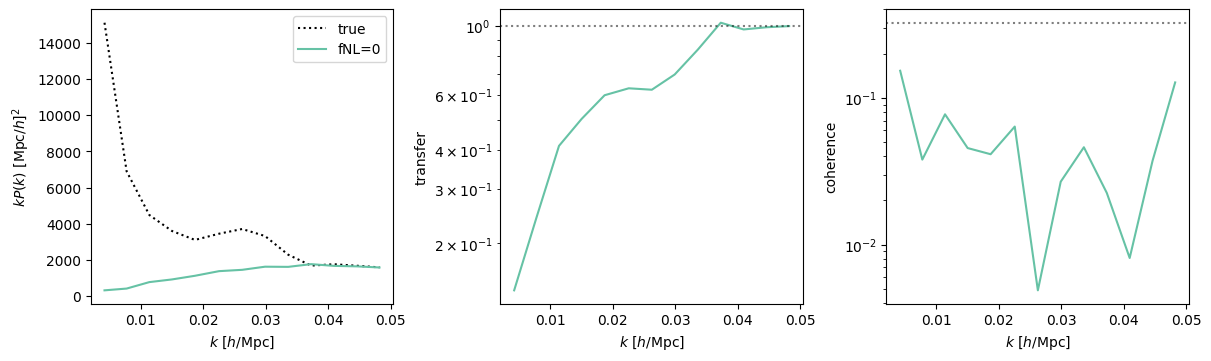

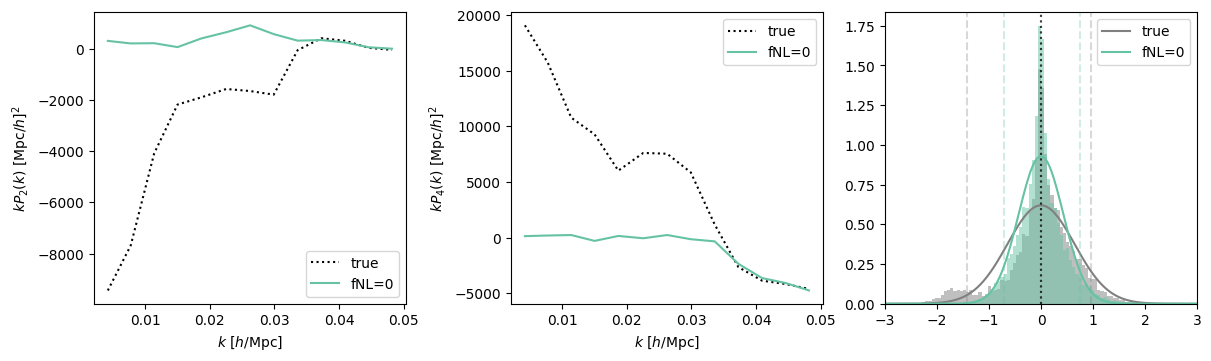

In [10]:
from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
from matplotlib import colors
theme(usetex=False)
axis = 0
ids = .1
log = False
# names = ["osamp1.5", 'osamp2']
names = ["fNL=0", 'fNL=50']
# names = ["rect", 'kb']
# names = ["red" 'red2', 'red3']
# names = ["tracer", 'tracer2', 'tracer3']
# names = ["matter", 'matter2', 'matter3']
# names = [
#     "$k_\\mathrm{evolve} = k_\\mathrm{paint} = 1.00\\, k_\\mathrm{final}$",
#     "$k_\\mathrm{evolve} = k_\\mathrm{paint} = 1.25\\, k_\\mathrm{final}$",
#     "$k_\\mathrm{evolve} = k_\\mathrm{paint} = 1.50\\, k_\\mathrm{final}$",
# ]
# deltas = [delta_obs1, delta_obs2, delta_obs3]
# deltas = [delta_obs1, delta_obs2]
deltas = [delta_obs1]
prefix = f"m{model.final_shape[0]}_red_interl2_iosamp1"
cmap = None
print(f"{prefix=}")

plt.figure(figsize=(12, 3.5), layout="constrained")
plt.subplot(131)
plot_pow(*model.spectrum(delta_obs0), 'k:', log=log, label="true")
for delta, name in zip(deltas, names):
    kptc = model.powtranscoh(delta_obs0, delta)
    plot_powtranscoh(*kptc, log=log, label=name)
    print(f"MSE {name}: {((delta - delta_obs0)**2).mean():.5e}")
plt.subplot(131)
plt.legend()
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_kptc.png")
# plt.savefig(f"./figs/{prefix}_tracer_real_oversampling_kptc.png")
# plt.savefig(f"./figs/{prefix}_tracer_redshift_badaxis_oversampling_kptc.png")


plt.figure(figsize=(12, 3.5), layout="constrained")
for i_plt, ell in enumerate((2,4)):
    plt.subplot(1,3,i_plt+1)
    kpow0 = model.spectrum(delta_obs0, poles=(0,2,4))
    plot_pow(*kpow0, 'k:', ell=ell, log=log, label="true")
    for delta, name in zip(deltas, names):
        kpow = model.spectrum(delta, poles=(0,2,4))
        plot_pow(*kpow, ell=ell, log=log, label=name)
    plt.legend()

plt.subplot(1,3,3)
vlim = -3, 3.
# vlim = -2, 2.
# plot_pdf(jnp.log10(jnp.maximum(1+delta_obs0, 1e-3)), "true", vlim)
# plot_pdf(jnp.log10(jnp.maximum(1+delta_obs1, 1e-3)), "sim", vlim)
plot_pdf(delta_obs0, "true", vlim, color='grey')
for delta, name in zip(deltas, names):
    plot_pdf(delta, name, vlim)
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_pdf.png")

prefix='m96_red_interl2_iosamp1'
MSE fNL=0: 1.25356e+00
mean: 2.22912e-16, std: 1.46163e+00, mesh p.05-.95: [-2.16560814  2.69549713]
mean: 1.96457e-16, std: 1.44975e+00, mesh p.05-.95: [-2.162136    2.65797083]


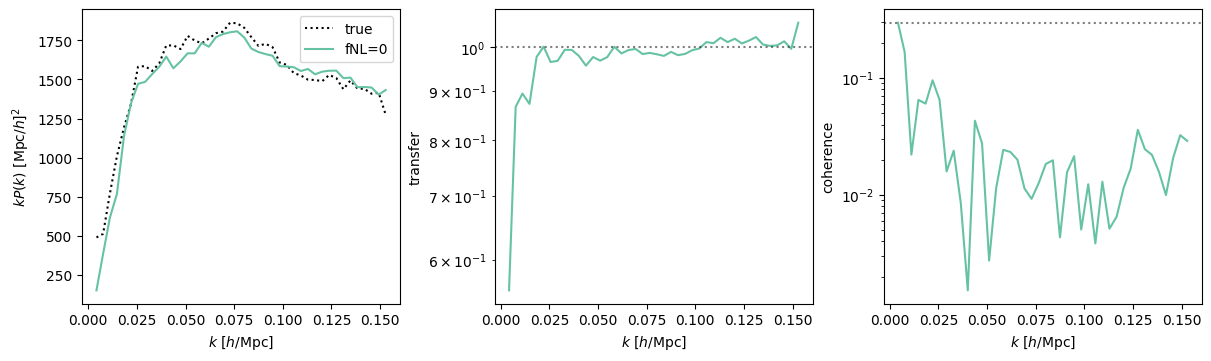

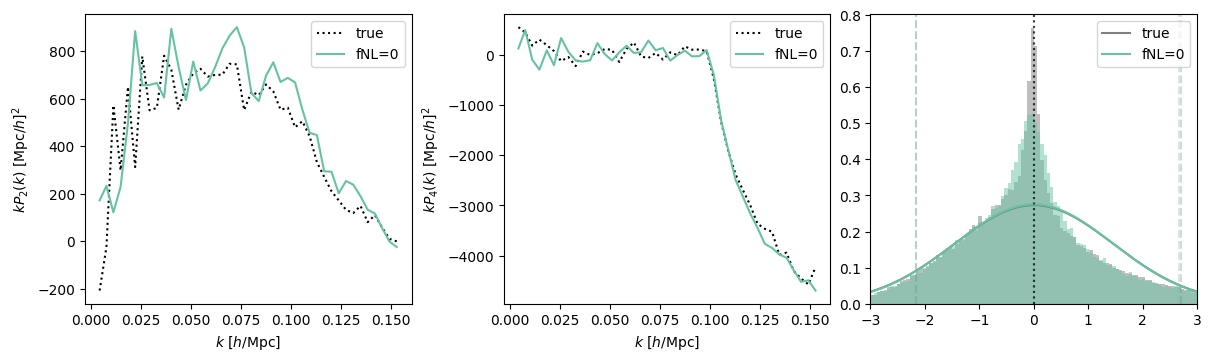

In [ ]:
from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
from matplotlib import colors
theme(usetex=False)
axis = 0
ids = .1
log = False
# names = ["osamp1.5", 'osamp2']
names = ["fNL=0", 'fNL=50']
# names = ["rect", 'kb']
# names = ["red" 'red2', 'red3']
# names = ["tracer", 'tracer2', 'tracer3']
# names = ["matter", 'matter2', 'matter3']
# names = [
#     "$k_\\mathrm{evolve} = k_\\mathrm{paint} = 1.00\\, k_\\mathrm{final}$",
#     "$k_\\mathrm{evolve} = k_\\mathrm{paint} = 1.25\\, k_\\mathrm{final}$",
#     "$k_\\mathrm{evolve} = k_\\mathrm{paint} = 1.50\\, k_\\mathrm{final}$",
# ]
# deltas = [delta_obs1, delta_obs2, delta_obs3]
# deltas = [delta_obs1, delta_obs2]
deltas = [delta_obs1]
prefix = f"m{model.final_shape[0]}_red_interl2_iosamp1"
cmap = None
print(f"{prefix=}")

plt.figure(figsize=(12, 3.5), layout="constrained")
plt.subplot(131)
plot_pow(*model.spectrum(delta_obs0), 'k:', log=log, label="true")
for delta, name in zip(deltas, names):
    kptc = model.powtranscoh(delta_obs0, delta)
    plot_powtranscoh(*kptc, log=log, label=name)
    print(f"MSE {name}: {((delta - delta_obs0)**2).mean():.5e}")
plt.subplot(131)
plt.legend()
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_kptc.png")
# plt.savefig(f"./figs/{prefix}_tracer_real_oversampling_kptc.png")
# plt.savefig(f"./figs/{prefix}_tracer_redshift_badaxis_oversampling_kptc.png")


plt.figure(figsize=(12, 3.5), layout="constrained")
for i_plt, ell in enumerate((2,4)):
    plt.subplot(1,3,i_plt+1)
    kpow0 = model.spectrum(delta_obs0, poles=(0,2,4))
    plot_pow(*kpow0, 'k:', ell=ell, log=log, label="true")
    for delta, name in zip(deltas, names):
        kpow = model.spectrum(delta, poles=(0,2,4))
        plot_pow(*kpow, ell=ell, log=log, label=name)
    plt.legend()

plt.subplot(1,3,3)
vlim = -3, 3.
# vlim = -2, 2.
# plot_pdf(jnp.log10(jnp.maximum(1+delta_obs0, 1e-3)), "true", vlim)
# plot_pdf(jnp.log10(jnp.maximum(1+delta_obs1, 1e-3)), "sim", vlim)
plot_pdf(delta_obs0, "true", vlim, color='grey')
for delta, name in zip(deltas, names):
    plot_pdf(delta, name, vlim)
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_pdf.png")

prefix='m96_red_interl2_iosamp1'
MSE fNL=0: 1.25143e+00
mean: 2.22912e-16, std: 1.46163e+00, mesh p.05-.95: [-2.16560814  2.69549713]
mean: -3.12250e-17, std: 1.44969e+00, mesh p.05-.95: [-2.15672996  2.64067316]


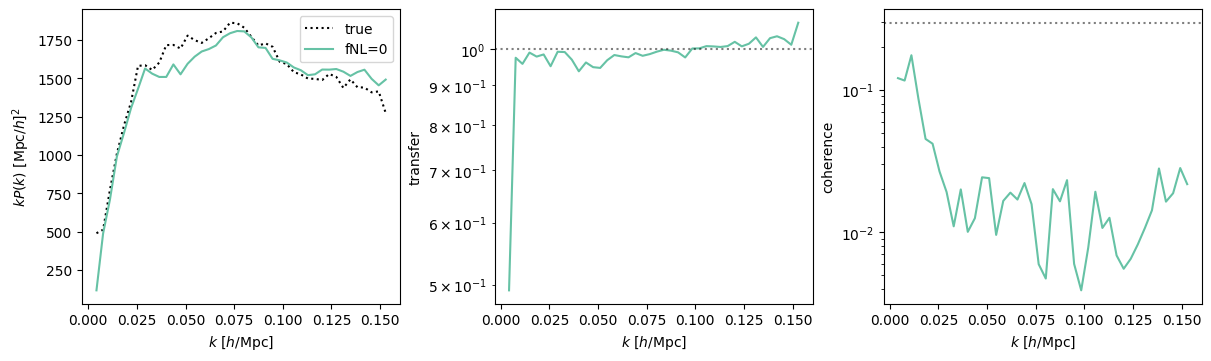

In [ ]:
from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
from matplotlib import colors
theme(usetex=False)
axis = 0
ids = .1
log = False
# names = ["osamp1.5", 'osamp2']
names = ["fNL=0", 'fNL=50']
# names = ["rect", 'kb']
# names = ["red" 'red2', 'red3']
# names = ["tracer", 'tracer2', 'tracer3']
# names = ["matter", 'matter2', 'matter3']
# names = [
#     "$k_\\mathrm{evolve} = k_\\mathrm{paint} = 1.00\\, k_\\mathrm{final}$",
#     "$k_\\mathrm{evolve} = k_\\mathrm{paint} = 1.25\\, k_\\mathrm{final}$",
#     "$k_\\mathrm{evolve} = k_\\mathrm{paint} = 1.50\\, k_\\mathrm{final}$",
# ]
# deltas = [delta_obs1, delta_obs2, delta_obs3]
# deltas = [delta_obs1, delta_obs2]
deltas = [delta_obs1]
prefix = f"m{model.final_shape[0]}_red_interl2_iosamp1"
cmap = None
print(f"{prefix=}")

plt.figure(figsize=(12, 3.5), layout="constrained")
plt.subplot(131)
plot_pow(*model.spectrum(delta_obs0), 'k:', log=log, label="true")
for delta, name in zip(deltas, names):
    kptc = model.powtranscoh(delta_obs0, delta)
    plot_powtranscoh(*kptc, log=log, label=name)
    print(f"MSE {name}: {((delta - delta_obs0)**2).mean():.5e}")
plt.subplot(131)
plt.legend()
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_kptc.png")
# plt.savefig(f"./figs/{prefix}_tracer_real_oversampling_kptc.png")
# plt.savefig(f"./figs/{prefix}_tracer_redshift_badaxis_oversampling_kptc.png")


plt.figure(figsize=(12, 3.5), layout="constrained")
for i_plt, ell in enumerate((2,4)):
    plt.subplot(1,3,i_plt+1)
    kpow0 = model.spectrum(delta_obs0, poles=(0,2,4))
    plot_pow(*kpow0, 'k:', ell=ell, log=log, label="true")
    for delta, name in zip(deltas, names):
        kpow = model.spectrum(delta, poles=(0,2,4))
        plot_pow(*kpow, ell=ell, log=log, label=name)
    plt.legend()

plt.subplot(1,3,3)
vlim = -3, 3.
# vlim = -2, 2.
# plot_pdf(jnp.log10(jnp.maximum(1+delta_obs0, 1e-3)), "true", vlim)
# plot_pdf(jnp.log10(jnp.maximum(1+delta_obs1, 1e-3)), "sim", vlim)
plot_pdf(delta_obs0, "true", vlim, color='grey')
for delta, name in zip(deltas, names):
    plot_pdf(delta, name, vlim)
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_pdf.png")

prefix='m96_red_interl2_iosamp1'
MSE fNL=0: 2.00829e-01
mean: 1.80218e-16, std: 1.15110e+00, mesh p.05-.95: [-1.46768152  2.16420237]
mean: 1.52110e-16, std: 1.16613e+00, mesh p.05-.95: [-1.52042732  2.16750391]


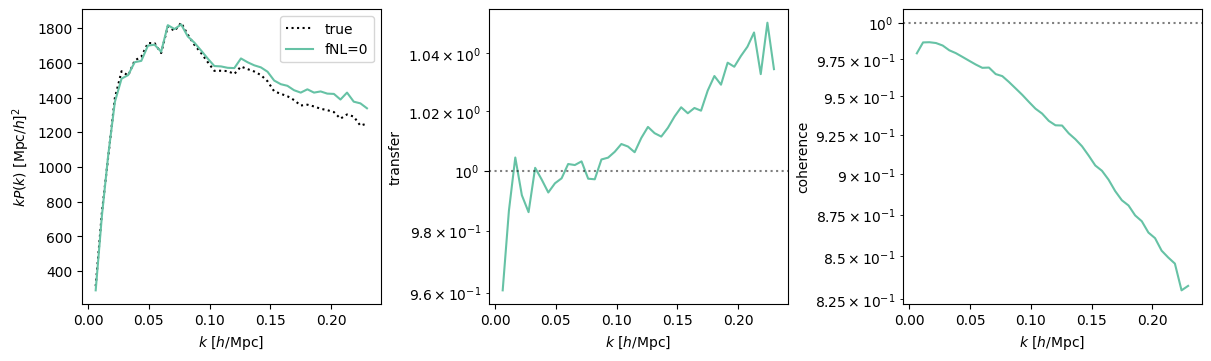

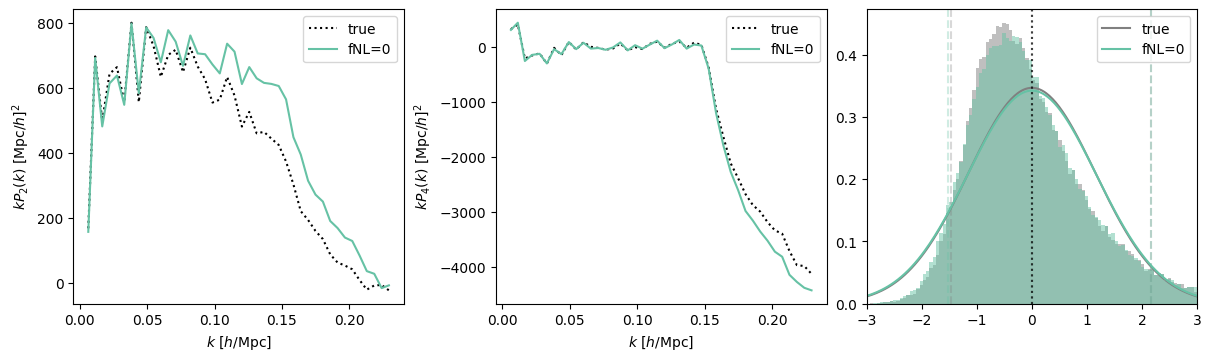

In [ ]:
from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
from matplotlib import colors
theme(usetex=False)
axis = 0
ids = .1
log = False
# names = ["osamp1.5", 'osamp2']
names = ["fNL=0", 'fNL=50']
# names = ["rect", 'kb']
# names = ["red" 'red2', 'red3']
# names = ["tracer", 'tracer2', 'tracer3']
# names = ["matter", 'matter2', 'matter3']
# names = [
#     "$k_\\mathrm{evolve} = k_\\mathrm{paint} = 1.00\\, k_\\mathrm{final}$",
#     "$k_\\mathrm{evolve} = k_\\mathrm{paint} = 1.25\\, k_\\mathrm{final}$",
#     "$k_\\mathrm{evolve} = k_\\mathrm{paint} = 1.50\\, k_\\mathrm{final}$",
# ]
# deltas = [delta_obs1, delta_obs2, delta_obs3]
# deltas = [delta_obs1, delta_obs2]
deltas = [delta_obs1]
prefix = f"m{model.final_shape[0]}_red_interl2_iosamp1"
cmap = None
print(f"{prefix=}")

plt.figure(figsize=(12, 3.5), layout="constrained")
plt.subplot(131)
plot_pow(*model.spectrum(delta_obs0), 'k:', log=log, label="true")
for delta, name in zip(deltas, names):
    kptc = model.powtranscoh(delta_obs0, delta)
    plot_powtranscoh(*kptc, log=log, label=name)
    print(f"MSE {name}: {((delta - delta_obs0)**2).mean():.5e}")
plt.subplot(131)
plt.legend()
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_kptc.png")
# plt.savefig(f"./figs/{prefix}_tracer_real_oversampling_kptc.png")
# plt.savefig(f"./figs/{prefix}_tracer_redshift_badaxis_oversampling_kptc.png")


plt.figure(figsize=(12, 3.5), layout="constrained")
for i_plt, ell in enumerate((2,4)):
    plt.subplot(1,3,i_plt+1)
    kpow0 = model.spectrum(delta_obs0, poles=(0,2,4))
    plot_pow(*kpow0, 'k:', ell=ell, log=log, label="true")
    for delta, name in zip(deltas, names):
        kpow = model.spectrum(delta, poles=(0,2,4))
        plot_pow(*kpow, ell=ell, log=log, label=name)
    plt.legend()

plt.subplot(1,3,3)
vlim = -3, 3.
# vlim = -2, 2.
# plot_pdf(jnp.log10(jnp.maximum(1+delta_obs0, 1e-3)), "true", vlim)
# plot_pdf(jnp.log10(jnp.maximum(1+delta_obs1, 1e-3)), "sim", vlim)
plot_pdf(delta_obs0, "true", vlim, color='grey')
for delta, name in zip(deltas, names):
    plot_pdf(delta, name, vlim)
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_pdf.png")

### Post pred 

In [ ]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload , Path
from montecosmo.chains import Chains
save_dir = Path("/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z08_lrg/tracer_redshift_eh0_ovsamp2_s81_bnp/lpt_32/")
model = FieldLevelModel.load(save_dir / "model.yaml")
truth = dict(jnp.load(save_dir / 'truth.npz'))
chains = pload(save_dir / 'test_chains_mesh.p')
out = pload(save_dir / 'test_chains_pred.p')


# print(chains.shape)
# # chains = Chains(dict(jnp.load(save_dir / 'test_1.npz')))
# # print(chains.shape)
# out = chains | pmap(lambda x: model.predict(samples=x, batch_ndim=1))(chains.data)
# print(out.shape)
# out['kptc_pred'] = pmap(vmap(lambda x: model.powtranscoh(model.count2delta(truth['obs']), model.count2delta(x))))(out['obs'])
# out['kpows_pred'] = pmap(vmap(lambda x: model.spectrum(model.count2delta(x), poles=(0,2,4))))(out['obs'])
# print(out.shape)
# pdump(out, save_dir / 'test_chains_pred.p')

prefix='m32_red_interl2_iosamp1'


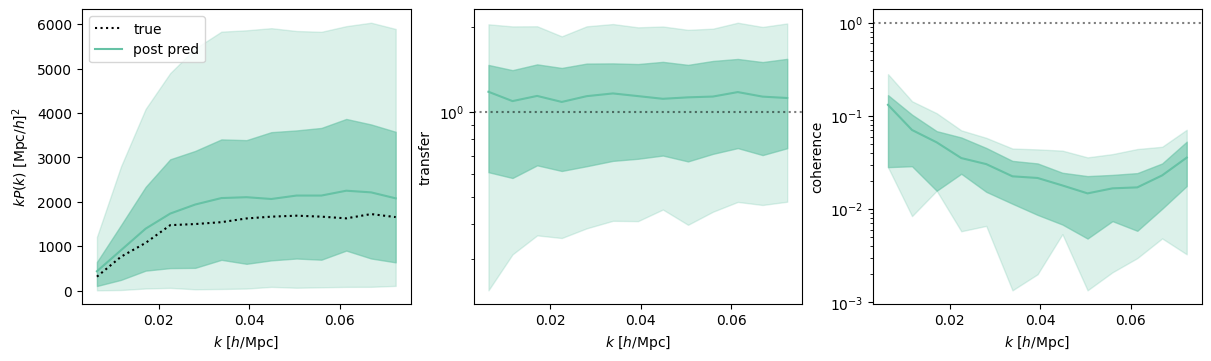

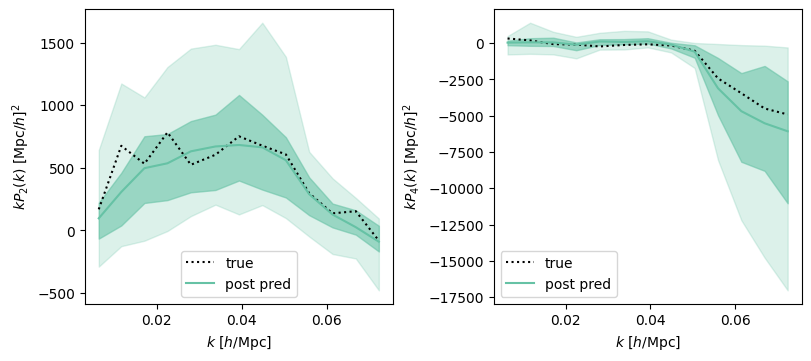

In [ ]:
from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
from matplotlib import colors
theme(usetex=False)
axis = 0
ids = .1
log = False
names = ["post pred"]
deltas = [out]
prefix = f"m{model.final_shape[0]}_red_interl2_iosamp1"
print(f"{prefix=}")

delta_obs0 = model.count2delta(truth['obs'])

plt.figure(figsize=(12, 3.5), layout="constrained")
plt.subplot(131)
plot_pow(*model.spectrum(delta_obs0), 'k:', log=log, label="true")
for delta, name in zip(deltas, names):
    kptc = tree.map(jnp.concatenate, delta)['kptc_pred']
    plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptc), log=log, label=name)
    plot_powtranscoh(*kptc, log=log, fill=(0.68,0.95))
    # print(f"MSE {name}: {((delta - delta_obs0)**2).mean():.5e}")
plt.subplot(131)
plt.legend()
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_kptc.png")
# plt.savefig(f"./figs/{prefix}_tracer_real_oversampling_kptc.png")
# plt.savefig(f"./figs/{prefix}_tracer_redshift_badaxis_oversampling_kptc.png")


plt.figure(figsize=(8, 3.5), layout="constrained")
for i_plt, ell in enumerate((2,4)):
    plt.subplot(1,2,i_plt+1)
    kpow0 = model.spectrum(delta_obs0, poles=(0,2,4))
    plot_pow(*kpow0, 'k:', ell=ell, log=log, label="true")
    for delta, name in zip(deltas, names):
        kpows = tree.map(jnp.concatenate, delta)['kpows_pred']
        plot_pow(*tree.map(lambda x: jnp.median(x, 0), kpows), ell=ell, log=log, label=name)
        plot_pow(*kpows, log=log, ell=ell, fill=(0.68,0.95))
    plt.legend()

# # plt.savefig(f"./figs/{prefix}_{"_".join(names)}_pdf.png")

### EFT

In [32]:
from montecosmo.nbody import gradient_hat, invlaplace_hat, a2g, rfftk, read, interlace
from montecosmo.bricks import Cosmology, AbacusSummit0, samp2base, regular_pos, rsd, tophysical_pos, phys2cell_pos
from montecosmo.utils import chreshape, r2chshape

save_dir2 = save_dir / "lagr"
save_dir2.mkdir(parents=True, exist_ok=True)

from numpyro import sample, deterministic, render_model, handlers, distributions as dist
from numpyro.infer.util import log_density
# lpt_pos, lpt_vel = jnp.load(load_dir / f"lpt_ptcl_osamp2.0_{mesh_length}.npy")
lpt_pos, lpt_vel = jnp.load(load_dir / f"lpt_ptcl_osamp1.5_2_{mesh_length}.npy")
init_mesh = jnp.fft.rfftn(jnp.load(load_dir / f'init_mesh_{576}.npy'))
init_mesh = chreshape(init_mesh, r2chshape(model.init_shape))
init_mesh = chreshape(init_mesh, r2chshape(model.evol_shape))
# delta_obs0 = jnp.load(load_dir / f'tracer_6746545_paint2_deconv1_{mesh_length}.npy') - 1
# delta_mat0 = jnp.load(load_dir / f'fin_paint2_interl2_deconv1_{mesh_length}.npy') - 1
# delta_obs0 = model.count2delta(truth0['obs'])
cosmo = AbacusSummit0()

In [33]:
def lagrangian_bias2(cosmo:Cosmology, pos, a, box_size, init_mesh, 
                       b1, b2, bs2, bn2, bnpar, fNL, png=None, read_order:int=2):
    delta = jnp.fft.irfftn(init_mesh)
    growths = a2g(cosmo, a)

    mesh_shape = delta.shape
    kvec = rfftk(mesh_shape)
    kmesh = sum((ki  * (m / b))**2 for ki, m, b in zip(kvec, mesh_shape, box_size))**.5 # in h/Mpc 

    # Init weights
    weights = 1.
    
    # Apply b1, punctual term
    delta_pos = read(pos, delta, read_order) * growths.squeeze()
    weights += b1 * delta_pos

    # Apply b2, punctual term
    delta2_pos = delta_pos**2
    weights += b2 * (delta2_pos - delta2_pos.mean())

    # Apply bshear2, non-punctual term
    pot = init_mesh * invlaplace_hat(kvec)
    dims = range(len(kvec))
    shear2 = 0.

    for i in dims:
        # Add diagonal terms
        nabi = gradient_hat(kvec, i)
        shear2 += jnp.fft.irfftn(nabi**2 * pot - init_mesh / 3)**2
        for j in dims[i+1:]:
            # Add strict-up-triangle terms (counted twice)
            nabj = gradient_hat(kvec, j)
            shear2 += 2 * jnp.fft.irfftn(nabi * nabj * pot)**2

    shear2_pos = read(pos, shear2, read_order) * growths.squeeze()**2
    weights += bs2 * (shear2_pos - shear2_pos.mean())

    # Apply bnabla2, higher-order term
    delta_nab2 = jnp.fft.irfftn( - kmesh**2 * init_mesh)

    delta_nab2_pos = read(pos, delta_nab2, read_order) * growths.squeeze()
    weights += bn2 * delta_nab2_pos

    # Compute separately bnablapar, velocity bias term
    delta_nabpar_pos = jnp.stack([
                read(pos, jnp.fft.irfftn(gradient_hat(kvec, i) * (m / b) * init_mesh), read_order) 
                for i, (m, b) in enumerate(zip(mesh_shape, box_size))], axis=-1) # in h/Mpc 
    dvel = bnpar * delta_nabpar_pos * growths
    # dvel = 0.

    return weights, dvel

def euler_bias2(cosmo:Cosmology, a, box_size, evol_mesh, 
                       b1, b2, bs2, bn2, bnp, fNL, png=None, read_order:int=2):
    delta = jnp.fft.irfftn(evol_mesh)

    mesh_shape = delta.shape
    kvec = rfftk(mesh_shape)
    kmesh = sum((ki  * (m / b))**2 for ki, m, b in zip(kvec, mesh_shape, box_size))**.5 # in h/Mpc 

    # Init weights
    weights = 1.
    
    # Apply b1, punctual term
    weights += b1 * delta

    # Apply b2, punctual term
    weights += b2 * (delta**2 - (delta**2).mean())

    # Apply bshear2, non-punctual term
    pot = evol_mesh * invlaplace_hat(kvec)
    dims = range(len(kvec))
    shear2 = 0.

    for i in dims:
        # Add diagonal terms
        nabi = gradient_hat(kvec, i)
        shear2 += jnp.fft.irfftn(nabi**2 * pot - evol_mesh / 3)**2
        for j in dims[i+1:]:
            # Add strict-up-triangle terms (counted twice)
            nabj = gradient_hat(kvec, j)
            shear2 += 2 * jnp.fft.irfftn(nabi * nabj * pot)**2

    weights += bs2 * (shear2 - shear2.mean())

    # Apply bnabla2, higher-order term
    delta_nab2 = jnp.fft.irfftn( - kmesh**2 * evol_mesh)
    weights += bn2 * delta_nab2

    # # Compute separately bnablapar, velocity bias term
    # delta_nabpar = jnp.stack([
    #             jnp.fft.irfftn(gradient_hat(kvec, i) * (m / b) * evol_mesh) 
    #             for i, (m, b) in enumerate(zip(mesh_shape, box_size))], axis=-1) # in h/Mpc 
    # dvel = bnp * delta_nabpar
    dvel = 0.

    return weights, dvel


def prior(temp=1.):
    # Sample, reparametrize, and register cosmology and biases
    tup = ()
    for g in ['bias','syst']:
        dic = model._sample(model.groups[g]) # sample               
        dic = samp2base(dic, model.latents, inv=False, temp=temp) # reparametrize
        tup += ({k: deterministic(k, v) for k, v in dic.items()},) # register base params

    bias, syst = tup
    if 'b1' in bias:
        bias['b1'] = model.reparam_b1(bias['b1'], cosmo.sigma8, eulerian=False)
        if 'b2' in bias:
            bias['b2'] = model.reparam_b2(bias['b2'], bias['b1'], cosmo.sigma8, eulerian=False)
    return bias, syst


def lagr_model():
    bias, syst = prior()
    cosmo._workspace = {} # HACK: force recompute by jaxpm cosmo to get g2, f2 => TODO: add g2, f2 to jaxcosmo
    pos = regular_pos(model.evol_shape, model.ptcl_shape)
    lbe_weights, dvel = lagrangian_bias2(cosmo, pos, model.a_obs, model.box_size, init_mesh=init_mesh, **bias, read_order=1)

    # ebe_weights, dvel = euler_bias2(cosmo, model.a_obs, model.box_size, delta_mat0, **bias, read_order=1)

    # RSD
    pos, rpos, los, a = tophysical_pos(lpt_pos, model.box_center, model.box_rot, model.box_size, model.evol_shape,
                        cosmo, model.a_obs, model.curved_sky)        
    dpos = rsd(cosmo, lpt_vel, los, model.a_obs, model.box_rot, model.box_size, model.evol_shape, dvel)
    pos += dpos
    pos = phys2cell_pos(pos, model.box_center, model.box_rot, model.box_size, model.paint_shape)

    # pos = lpt_pos * model.paint_shape / model.ptcl_shape
    mesh = interlace(pos, model.paint_shape, lbe_weights, model.paint_order, model.interlace_order, 
                        kernel_type=model.kernel_type, oversamp=model.paint_oversamp, deconv=model.paint_deconv)
    mesh *= (model.paint_shape / model.ptcl_shape).prod()
    mesh = chreshape(mesh, r2chshape(model.final_shape))
    mesh = jnp.fft.irfftn(mesh)

    obs = model.likelihood((mesh, syst))
    return obs

    # mesh -= 1
    # # print("mesh", mesh.mean(), mesh.std(), mesh.min(), mesh.max())
    
    # rcounts = syst['ngbars'] * model.cell_length**3
    # mean_count = rcounts.mean()

    # # obs = sample('obs', dist.Normal((1 + mesh) * mean_count, mean_count**.5))
    # # obs = sample('obs', dist.Normal(mesh, mean_count**-.5))

    # # posit_fn = lambda x: jnp.maximum(x, 1e-9)
    # # posit_fn = jnp.abs
    # posit_fn = lambda x: jnp.log(1 + jnp.exp(x))
    # obs = sample('obs', dist.Normal(mesh, (posit_fn(1 + syst['sigma_delta'] * mesh) / mean_count)**.5))

    # # obs = sample('obs', dist.Poisson(jnp.maximum(1 + mesh, 1e-9) * mean_count)) # / mean_count - 1
    # # obs = sample('obs', dist.Poisson(jnp.abs(1 + mesh) * mean_count)) # / mean_count - 1
    # return obs

from montecosmo.metrics import _waves
from montecosmo.utils import safe_div

def spetrum_kcount(mesh_shape, box_size, kedges:int|float|list=None, box_center:tuple=(0.,0.,0.)):
    # Initialize
    box_center = np.asarray(box_center)
    los = safe_div(box_center, np.linalg.norm(box_center))
    kedges, kmesh, mumesh, rfftw = _waves(mesh_shape, box_size, kedges, los)
    n_bins = len(kedges) + 1
    dig = np.digitize(kmesh.reshape(-1), kedges)

    # Count wavenumber in bins
    kcount = np.bincount(dig, weights=rfftw.reshape(-1), minlength=n_bins)[1:-1]
    return kcount

### Fit EFT

In [34]:
params_names = ['b1','b2','bs2','bn2','bnpar','ngbars', 'sigma_0', 'sigma_delta']
# params_names = ['b1','b2','bs2','bn2','ngbars', 'sigma_0', 'sigma_delta']
# params_names = ['b1','b2','bs2','bn2','ngbars']
# params_names = ['b1','b2','bs2','bn2']
params_start_ = {k: v for k, v in model.loc_fid.items() if k in params_names}
params_start_['b1'] = 1.17
# params_start_['b1'] = 1.
print(params_start_)
params_start_ = model.reparam(params_start_, inv=True)
print('start params:', params_start_.keys())

data = model.reparam({
                    'obs': truth0['obs'], ############
                    # 'obs': (truth0['obs']+1)*model.count_fid, 
                    # 'ngbars': truth0['ngbars'],
                    #   'ngbars': 1000,
                    # 'bnpar':0., 
                    'fNL':0.,}, inv=True)
cond_lagr_model = handlers.condition(lagr_model, data=data)
def potential(params={}):
    return - log_density(cond_lagr_model, (), {}, params)[0]

# render_model(cond_eft_model)
# potential_valgrad = (value_and_grad(potential))
potential_valgrad = jit(value_and_grad(potential))
potential_valgrad(params_start_)[0]

{'b1': 1.17, 'b2': 0.2, 'bs2': -0.2, 'bn2': 0.0, 'bnpar': 0.0, 'ngbars': array([0.00084332]), 'sigma_0': 0.6, 'sigma_delta': 0.6}
start params: dict_keys(['b1_', 'b2_', 'bs2_', 'bn2_', 'bnpar_', 'ngbars_', 'sigma_0_', 'sigma_delta_'])


Array(749779.49596005, dtype=float64)

MSE start: 5.92619e-02
MSE mode: 5.92619e-02
mean: -7.02563e-17, std: 7.90768e-01, mesh p.05-.95: [-1.10632714  1.44152506]
mean: -9.62772e-17, std: 8.04648e-01, mesh p.05-.95: [-1.13390256  1.46362438]
mean: -8.41341e-17, std: 8.04648e-01, mesh p.05-.95: [-1.13390256  1.46362438]


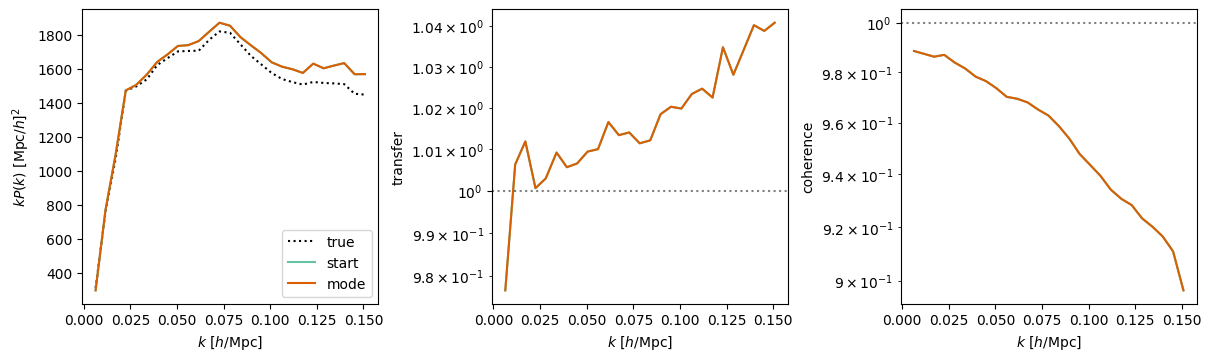

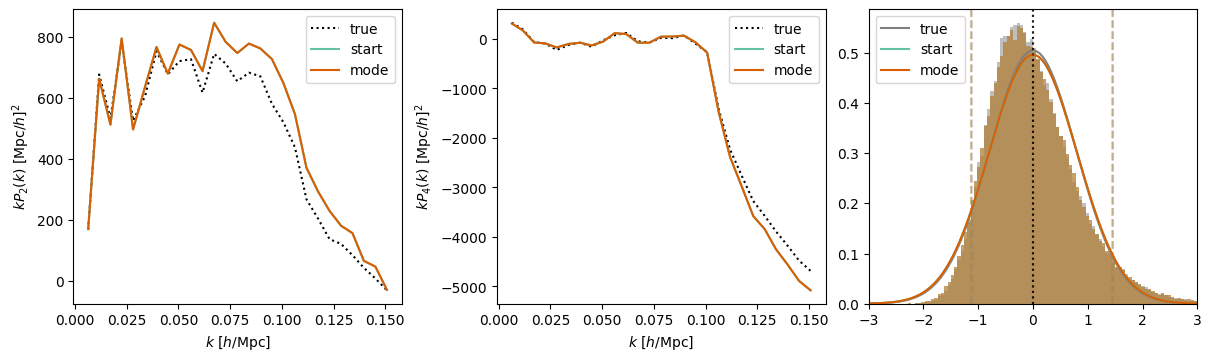

In [37]:
prefix = f"m{mesh_length}_lagr_red_{"_".join(params_names)}"
# params_ = dict(jnp.load(save_dir2 / f'params_mode_{prefix}.npz'))
params_ = params_start_
params = model.reparam(params_)

pred_lagr_model = handlers.condition(lagr_model, data={k:v for k,v in data.items() if k != "obs"} | params_start_)
delta_obs1 = model.count2delta((handlers.seed(pred_lagr_model, 42))())
# delta_obs1 = delta_obs1 / model.count_fid - 1
pred_lagr_model = handlers.condition(lagr_model, data={k:v for k,v in data.items() if k != "obs"} | params_)
delta_obs2 = model.count2delta((handlers.seed(pred_lagr_model, 42))())
# delta_obs2 = delta_obs2 / model.count_fid - 1
# display(render_model(pred_eft_model))

from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
theme(usetex=False)
log = False
names = ['start', 'mode']
deltas = [delta_obs1, delta_obs2]

plt.figure(figsize=(12, 3.5), layout="constrained")
plt.subplot(131)
plot_pow(*model.spectrum(delta_obs0), 'k:', log=log, label="true")
for delta, name in zip(deltas, names):
    kptc = model.powtranscoh(delta_obs0, delta)
    plot_powtranscoh(*kptc, log=log, label=name)
    print(f"MSE {name}: {((delta - delta_obs0)**2).mean():.5e}")
plt.subplot(131)
plt.legend()
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);
plt.savefig(f"./figs/{prefix}_kptc.png")



plt.figure(figsize=(12, 3.5), layout="constrained")
for i_plt, ell in enumerate((2,4)):
    plt.subplot(1,3,i_plt+1)
    kpow0 = model.spectrum(delta_obs0, poles=(0,2,4))
    plot_pow(*kpow0, 'k:', ell=ell, log=log, label="true")
    for delta, name in zip(deltas, names):
        kpow = model.spectrum(delta, poles=(0,2,4))
        plot_pow(*kpow, ell=ell, log=log, label=name)
    plt.legend()

plt.subplot(1,3,3)
vlim = -3, 3.
# vlim = -2, 2.
# plot_pdf(jnp.log10(jnp.maximum(1+delta_obs0, 1e-3)), "true", vlim)
# plot_pdf(jnp.log10(jnp.maximum(1+delta_obs1, 1e-3)), "sim", vlim)
plot_pdf(delta_obs0, "true", vlim, color='grey')
for delta, name in zip(deltas, names):
    plot_pdf(delta, name, vlim)
plt.savefig(f"./figs/{prefix}_pdf.png")

MSE start: 2.01032e-01
MSE mode: 1.86311e-01
mean: 1.80218e-16, std: 1.15110e+00, mesh p.05-.95: [-1.46768152  2.16420237]
mean: 7.26014e-18, std: 1.16706e+00, mesh p.05-.95: [-1.52022284  2.16560984]
mean: 1.27245e-16, std: 1.15632e+00, mesh p.05-.95: [-1.48488733  2.15862302]


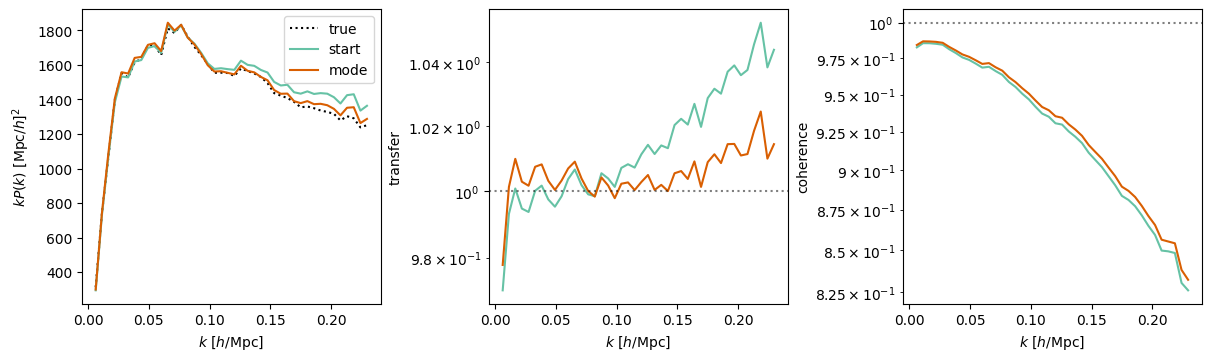

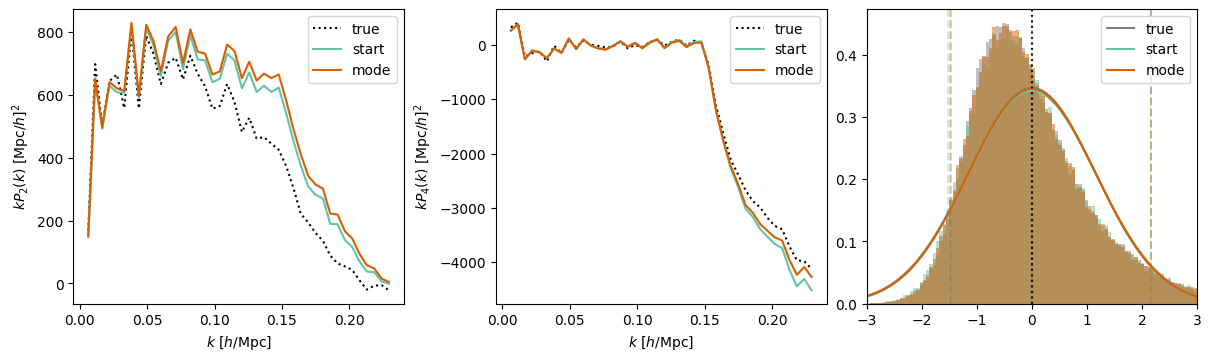

In [ ]:
prefix = f"m{mesh_length}_lagr_red_{"_".join(params_names)}"
params_ = dict(jnp.load(save_dir2 / f'params_mode_{prefix}.npz'))
# params_ = params_start_
params = model.reparam(params_)

pred_lagr_model = handlers.condition(lagr_model, data={k:v for k,v in data.items() if k != "obs"} | params_start_)
delta_obs1 = model.count2delta((handlers.seed(pred_lagr_model, 42))())
# delta_obs1 = delta_obs1 / model.count_fid - 1
pred_lagr_model = handlers.condition(lagr_model, data={k:v for k,v in data.items() if k != "obs"} | params_)
delta_obs2 = model.count2delta((handlers.seed(pred_lagr_model, 42))())
# delta_obs2 = delta_obs2 / model.count_fid - 1
# display(render_model(pred_eft_model))

from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
theme(usetex=False)
log = False
names = ['start', 'mode']
deltas = [delta_obs1, delta_obs2]

plt.figure(figsize=(12, 3.5), layout="constrained")
plt.subplot(131)
plot_pow(*model.spectrum(delta_obs0), 'k:', log=log, label="true")
for delta, name in zip(deltas, names):
    kptc = model.powtranscoh(delta_obs0, delta)
    plot_powtranscoh(*kptc, log=log, label=name)
    print(f"MSE {name}: {((delta - delta_obs0)**2).mean():.5e}")
plt.subplot(131)
plt.legend()
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);
plt.savefig(f"./figs/{prefix}_kptc.png")



plt.figure(figsize=(12, 3.5), layout="constrained")
for i_plt, ell in enumerate((2,4)):
    plt.subplot(1,3,i_plt+1)
    kpow0 = model.spectrum(delta_obs0, poles=(0,2,4))
    plot_pow(*kpow0, 'k:', ell=ell, log=log, label="true")
    for delta, name in zip(deltas, names):
        kpow = model.spectrum(delta, poles=(0,2,4))
        plot_pow(*kpow, ell=ell, log=log, label=name)
    plt.legend()

plt.subplot(1,3,3)
vlim = -3, 3.
# vlim = -2, 2.
# plot_pdf(jnp.log10(jnp.maximum(1+delta_obs0, 1e-3)), "true", vlim)
# plot_pdf(jnp.log10(jnp.maximum(1+delta_obs1, 1e-3)), "sim", vlim)
plot_pdf(delta_obs0, "true", vlim, color='grey')
for delta, name in zip(deltas, names):
    plot_pdf(delta, name, vlim)
plt.savefig(f"./figs/{prefix}_pdf.png")

In [42]:
from jax.example_libraries.optimizers import adam
from tqdm import tqdm
n_epochs = 100
energies = []

lr0 = 1.
# lr_fn = lambda i: lr0 / (1 + i)**.5
lr_fn = 1e-1
opt_init, opt_update, get_params = adam(lr_fn)
# opt_state = opt_init(params_start_)
opt_state = opt_init(params_)

def step(step, opt_state):
    value, pot_grad = potential_valgrad(get_params(opt_state))
    opt_state = opt_update(step, pot_grad, opt_state)
    return value, opt_state

for i_epoch in tqdm(range(n_epochs)):
    value, opt_state = step(i_epoch, opt_state)
    energies.append(float(value))
params_ = get_params(opt_state)
jnp.savez(save_dir2 / f'params_mode_{prefix}.npz', **params_)

100%|███████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.08it/s]


Last potential: 128701.4710124722
Final params:
 {'b1_': Array(1.77639839, dtype=float64), 'b2_': Array(1.61639708, dtype=float64), 'bn2_': Array(11.80426418, dtype=float64), 'bnpar_': Array(-8.24976346, dtype=float64), 'bs2_': Array(1.32158263, dtype=float64), 'ngbars_': Array([-0.22663279], dtype=float64), 'sigma_0_': Array(-1.32847978, dtype=float64), 'sigma_delta_': Array(1.05986685, dtype=float64)} 
 {'b1': Array(1.16776398, dtype=float64), 'b2': Array(0.24849191, dtype=float64), 'bs2': Array(-0.06784174, dtype=float64), 'bn2': Array(11.80426418, dtype=float64), 'bnpar': Array(-8.24976346, dtype=float64), 'ngbars': Array([0.00084325], dtype=float64), 'sigma_0': Array(0.56014561, dtype=float64), 'sigma_delta': Array(0.70598669, dtype=float64)}


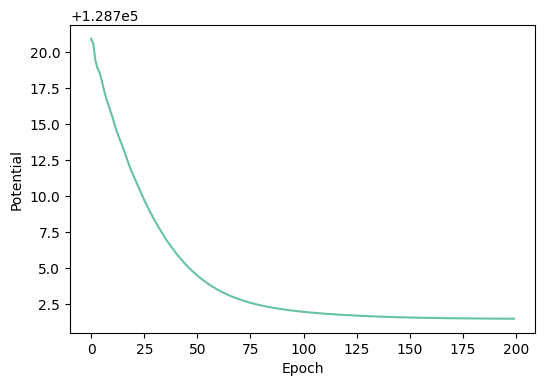

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energies)
print("Last potential:", energies[-1])
plt.xlabel("Epoch"), plt.ylabel("Potential")
params = model.reparam(params_)
print("Final params:\n", params_, '\n', params)
plt.show()

Last potential: 747473.6316314415
Final params:
 {'b1_': Array(0.62373682, dtype=float64), 'b2_': Array(1.58426231, dtype=float64), 'bn2_': Array(0.74596923, dtype=float64), 'bnp_': Array(-11.28842951, dtype=float64), 'bs2_': Array(0.14836289, dtype=float64), 'ngbars_': Array([-0.4043282], dtype=float64), 'sigma_0_': Array(-2.27997288, dtype=float64), 'sigma_delta_': Array(1.21367446, dtype=float64)} 
 {'b1': Array(1.15623737, dtype=float64), 'b2': Array(0.24752787, dtype=float64), 'bs2': Array(-0.18516371, dtype=float64), 'bn2': Array(0.74596923, dtype=float64), 'bnp': Array(-11.28842951, dtype=float64), 'ngbars': Array([0.0008432], dtype=float64), 'sigma_0': Array(0.53160081, dtype=float64), 'sigma_delta': Array(0.72136745, dtype=float64)}


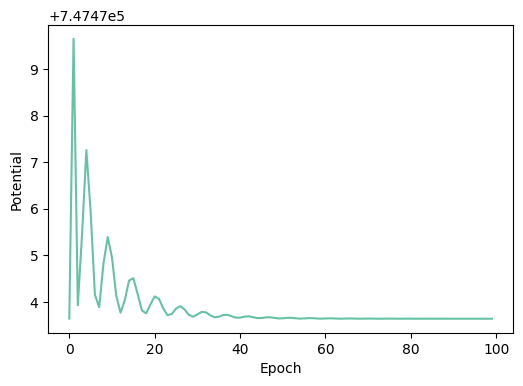

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energies)
print("Last potential:", energies[-1])
plt.xlabel("Epoch"), plt.ylabel("Potential")
params = model.reparam(params_)
print("Final params:\n", params_, '\n', params)
plt.show()

Last potential: 1960620.7776652952
Final params:
 {'b1_': Array(2.40095146, dtype=float64), 'b2_': Array(1.55790786, dtype=float64), 'bn2_': Array(4.35135157, dtype=float64), 'bnp_': Array(18.72987475, dtype=float64), 'bs2_': Array(0.40849112, dtype=float64), 'ngbars_': Array([-6.36236583], dtype=float64), 'sigma_0_': Array(-0.85121773, dtype=float64), 'sigma_delta_': Array(0.94634439, dtype=float64)} 
 {'b1': Array(1.17400951, dtype=float64), 'b2': Array(0.24673724, dtype=float64), 'bs2': Array(-0.15915089, dtype=float64), 'bn2': Array(4.35135157, dtype=float64), 'bnp': Array(18.72987475, dtype=float64), 'ngbars': Array([0.00084141], dtype=float64), 'sigma_0': Array(0.51487823, dtype=float64), 'sigma_delta': Array(0.69463444, dtype=float64)}


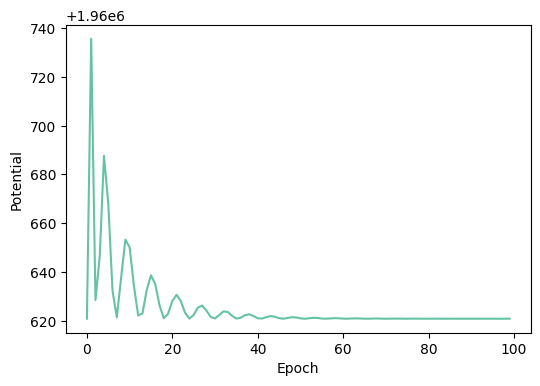

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energies)
print("Last potential:", energies[-1])
plt.xlabel("Epoch"), plt.ylabel("Potential")
params = model.reparam(params_)
print("Final params:\n", params_, '\n', params)
plt.show()

Last potential: 3900812.428394662
Final params:
 {'b1_': Array(6.00576091, dtype=float64), 'b2_': Array(2.93792863, dtype=float64), 'bn2_': Array(0.955546, dtype=float64), 'bs2_': Array(-2.36511329, dtype=float64), 'ngbars_': Array([0.13471851], dtype=float64), 'sigma_0_': Array(-3.39615606, dtype=float64), 'sigma_delta_': Array(-3.95297875, dtype=float64)} 
 {'b1': Array(1.20028805, dtype=float64), 'b2': Array(0.29379286, dtype=float64), 'bs2': Array(-0.23651133, dtype=float64), 'bn2': Array(0.955546, dtype=float64), 'ngbars': Array([0.00084345], dtype=float64), 'sigma_0': Array(0.0005037, dtype=float64), 'sigma_delta': Array(0.60470213, dtype=float64)}


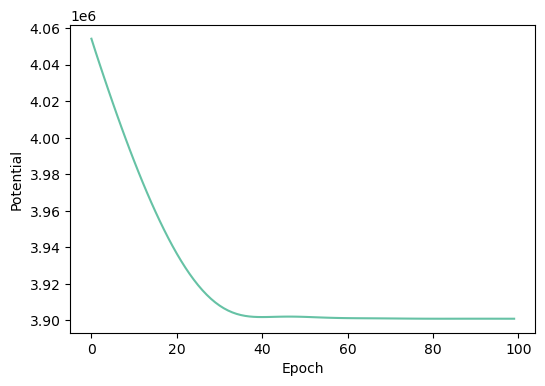

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energies)
print("Last potential:", energies[-1])
plt.xlabel("Epoch"), plt.ylabel("Potential")
params = model.reparam(params_)
print("Final params:\n", params_, '\n', params)
plt.show()

Last potential: 3903092.2041213023
Final params:
 {'b1_': Array(4.44587007, dtype=float64), 'b2_': Array(3.06682545, dtype=float64), 'bn2_': Array(-1.25521582, dtype=float64), 'bs2_': Array(-2.26231791, dtype=float64), 'ngbars_': Array([3.86735434], dtype=float64), 'sigma_0_': Array(-3.38733661, dtype=float64), 'sigma_delta_': Array(-4.00409623, dtype=float64)} 
 {'b1': Array(1.1222935, dtype=float64), 'b2': Array(0.30668254, dtype=float64), 'bs2': Array(-0.22623179, dtype=float64), 'bn2': Array(-1.25521582, dtype=float64), 'ngbars': Array([0.00084719], dtype=float64), 'sigma_0': Array(0.00050458, dtype=float64), 'sigma_delta': Array(0.59959038, dtype=float64)}


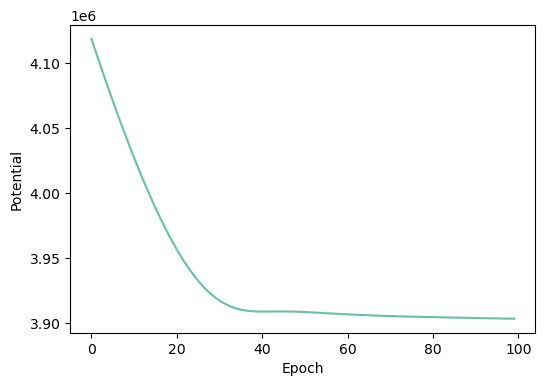

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energies)
print("Last potential:", energies[-1])
plt.xlabel("Epoch"), plt.ylabel("Potential")
params = model.reparam(params_)
print("Final params:\n", params_, '\n', params)
plt.show()

Last potential: 3900980.677159021
Final params:
 {'b1_': Array(1.53575572, dtype=float64), 'b2_': Array(2.97164289, dtype=float64), 'bn2_': Array(0.36372419, dtype=float64), 'bs2_': Array(-2.32173775, dtype=float64), 'ngbars_': Array([2.48261483], dtype=float64), 'sigma_0_': Array(-3.39987779, dtype=float64), 'sigma_delta_': Array(-3.9856637, dtype=float64)} 
 {'b1': Array(1.17678779, dtype=float64), 'b2': Array(0.29716429, dtype=float64), 'bs2': Array(-0.23217377, dtype=float64), 'bn2': Array(0.36372419, dtype=float64), 'ngbars': Array([0.0008458], dtype=float64), 'sigma_0': Array(0.00050333, dtype=float64), 'sigma_delta': Array(0.60143363, dtype=float64)}


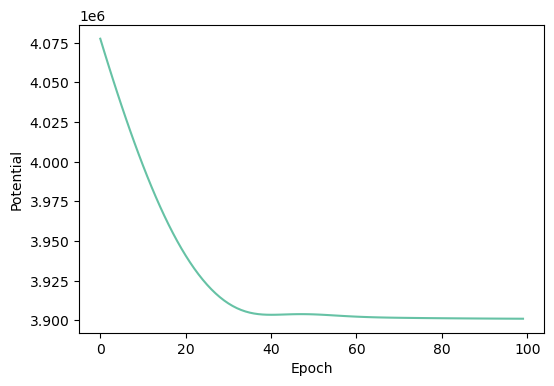

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energies)
print("Last potential:", energies[-1])
plt.xlabel("Epoch"), plt.ylabel("Potential")
params = model.reparam(params_)
print("Final params:\n", params_, '\n', params)
plt.show()

Last potential: 2056226.3277011965
Final params:
 {'b1_': Array(18.16647095, dtype=float64), 'b2_': Array(2.8243579, dtype=float64), 'bn2_': Array(0.94515626, dtype=float64), 'bs2_': Array(-2.06619385, dtype=float64), 'ngbars_': Array([-0.14546657], dtype=float64), 'sigma_0_': Array(-3.1418324, dtype=float64), 'sigma_delta_': Array(-3.86265629, dtype=float64)} 
 {'b1': Array(1.18166471, dtype=float64), 'b2': Array(0.28243579, dtype=float64), 'bs2': Array(-0.20661939, dtype=float64), 'bn2': Array(0.94515626, dtype=float64), 'ngbars': Array([0.00084317], dtype=float64), 'sigma_0': Array(0.00052913, dtype=float64), 'sigma_delta': Array(0.61373437, dtype=float64)}


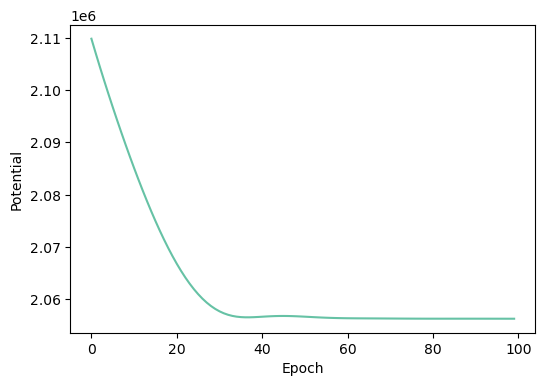

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energies)
print("Last potential:", energies[-1])
plt.xlabel("Epoch"), plt.ylabel("Potential")
params = model.reparam(params_)
print("Final params:\n", params_, '\n', params)
plt.show()

Last potential: 2059048.750518009
Final params:
 {'b1_': Array(6.88106271, dtype=float64), 'b2_': Array(2.98258102, dtype=float64), 'bn2_': Array(-3.99403294, dtype=float64), 'bs2_': Array(-2.01935874, dtype=float64), 'ngbars_': Array([5.50678976], dtype=float64), 'sigma_0_': Array(-3.11102152, dtype=float64), 'sigma_delta_': Array(-3.89849566, dtype=float64)} 
 {'b1': Array(1.06881063, dtype=float64), 'b2': Array(0.2982581, dtype=float64), 'bs2': Array(-0.20193587, dtype=float64), 'bn2': Array(-3.99403294, dtype=float64), 'ngbars': Array([0.00084882], dtype=float64), 'sigma_0': Array(0.00053222, dtype=float64), 'sigma_delta': Array(0.61015043, dtype=float64)}


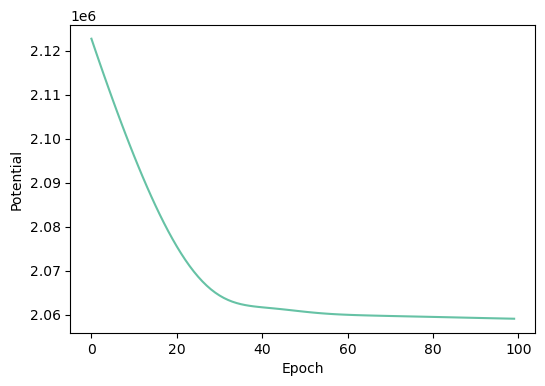

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energies)
print("Last potential:", energies[-1])
plt.xlabel("Epoch"), plt.ylabel("Potential")
params = model.reparam(params_)
print("Final params:\n", params_, '\n', params)
plt.show()

Last potential: 297321.44848034007
Final params:
 {'b1_': Array(16.01737699, dtype=float64), 'b2_': Array(2.90364448, dtype=float64), 'bn2_': Array(0.07532313, dtype=float64), 'bs2_': Array(-1.92330142, dtype=float64), 'ngbars_': Array([10.12522269], dtype=float64), 'sigma_delta_': Array(-1.72785117, dtype=float64)} 
 {'b1': Array(1.16017377, dtype=float64), 'b2': Array(0.29036445, dtype=float64), 'bs2': Array(-0.19233014, dtype=float64), 'bn2': Array(0.07532313, dtype=float64), 'ngbars': Array([0.00085013], dtype=float64), 'sigma_delta': Array(0.82721488, dtype=float64)}


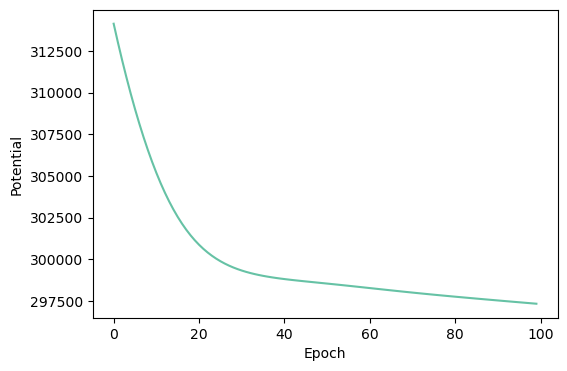

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energies)
print("Last potential:", energies[-1])
plt.xlabel("Epoch"), plt.ylabel("Potential")
params = model.reparam(params_)
print("Final params:\n", params_, '\n', params)
plt.show()

Last potential: 298406.25099462876
Final params:
 {'b1_': array(18.33722723), 'b2_': array(2.91309443), 'bn2_': array(1.46935295), 'bs2_': array(-1.80563572), 'ngbars_': array([10.04342102])} 
 {'b1': Array(1.18337227, dtype=float64), 'b2': Array(0.29130944, dtype=float64), 'bs2': Array(-0.18056357, dtype=float64), 'bn2': Array(1.46935295, dtype=float64), 'ngbars': Array([0.00085004], dtype=float64)}


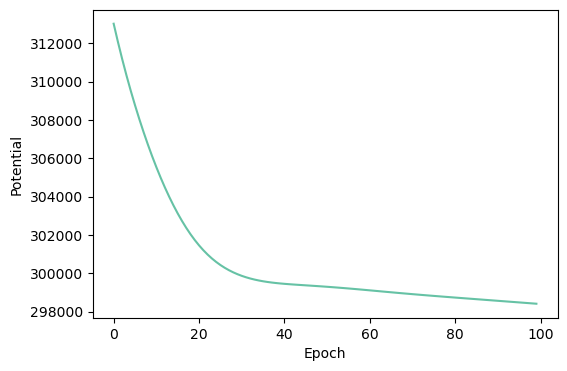

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energies)
print("Last potential:", energies[-1])
plt.xlabel("Epoch"), plt.ylabel("Potential")
print("Final params:\n", params_, '\n', model.reparam(params_))
plt.show()

In [ ]:
print("Final params:\n", params_, '\n', model.reparam(params_))

Final params:
 {'b1_': array(18.36147027), 'b2_': array(2.91450078), 'bn2_': array(1.46964203), 'bs2_': array(-1.80547173)} 
 {'b1': Array(1.1836147, dtype=float64), 'b2': Array(0.29145008, dtype=float64), 'bs2': Array(-0.18054717, dtype=float64), 'bn2': Array(1.46964203, dtype=float64)}


### Inspect noise

In [ ]:
pred_lagr_model = handlers.condition(lagr_model, data={k:v for k,v in data.items() if k != "obs"} | {'ngbars_':1e9, 'sigma_0_':1e9} | params_)
delta_obs1 = model.count2delta((handlers.seed(pred_lagr_model, 42))())
######### ngbars_ sigma0
pred_lagr_model = handlers.condition(lagr_model, data={k:v for k,v in data.items() if k != "obs"} | params_)
delta_obs0 = model.count2delta((handlers.seed(pred_lagr_model, 42))())
# delta_obs0 = model.count2delta(truth0['obs'])
noises = delta_obs0 - delta_obs1

# # from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
# # from matplotlib import colors
# theme(usetex=False, font_size=12)
# log = False

# plt.figure(figsize=(12, 3.5), layout="constrained")
# plt.subplot(131)
# plot_pow(*model.spectrum(delta_obs0), 'k:', log=log, label="tracer")
# kptc1 = model.powtranscoh(delta_obs0, delta_obs1)
# plot_powtranscoh(*kptc1, log=log, label="mode, no noise")
# plt.subplot(131)
# plt.legend()
# plt.subplot(132)
# plt.axhline(1., linestyle=':', color='k', alpha=0.5)
# plt.subplot(133)
# plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);

# plt.savefig(save_dir2 / f"{prefix}_nonkptc.png")




plt.figure(figsize=(12, 3.5), layout="constrained")
plt.subplot(131)
# print("noise mean:", noises.mean(), "std:", noises.std())
# plt.hist(jr.choice(jr.key(48), noises.ravel(), (50000,)), bins=100, density=True)
# x = np.linspace(noises.min(), noises.max(), 200)
# from scipy.stats import norm
# pdf = norm.pdf(x, loc=noises.mean(), scale=noises.std())
# plt.plot(x, pdf, label="Gaussian")

vlim = -4., 4.
plot_pdf(noises, "Gaussian", vlim)
plt.xlabel('$\\delta^\\mathrm{true} - \\bar\\delta^\\mathrm{fit}$')
plt.yscale('log')
plt.legend()


plt.subplot(132)
plot_pow(*model.spectrum(noises), log=True, label="noise")
plt.xscale('linear')
plt.axhline(1 / params['sigma_0'], color='k', linestyle=':', alpha=0.5)
plt.axhline(noises.var() * model.cell_length**3, color='k', linestyle='--', alpha=0.5)
plt.ylim(bottom=1.7e3)

plt.subplot(133)
def var_value(tmesh, vmesh, vedges:int|float|list, min_count=5):
    tmesh, vmesh = tmesh.reshape(-1), vmesh.reshape(-1)
    if isinstance(vedges, int):
        n_vedges = vedges
        vmin, vmax = vmesh.min(), vmesh.max()
        dv = (vmax - vmin) / n_vedges
        vedges = np.linspace(vmin, vmax, n_vedges, endpoint=False)
        vedges += dv / 2

    dig = np.digitize(vmesh, vedges)
    vcount = np.bincount(dig)[1:-1]
    vmask = vcount >= min_count
    vcount = vcount[vmask]

    vmean = np.bincount(dig, weights=vmesh)[1:-1]
    vmean = vmean[vmask]
    vmean = vmean / vcount

    tmean = np.bincount(dig, weights=tmesh)[1:-1]
    tmean = tmean[vmask]
    tmean = tmean / vcount

    tvar = np.bincount(dig, weights=tmesh**2)[1:-1]
    tvar = tvar[vmask]
    tvar = tvar / vcount
    tvar = tvar - tmean**2

    return vcount, vmean, tmean, tvar

vcount, vmean, tmean, tvar = var_value(noises * model.cell_length**(3/2), delta_obs1, 35, 5)

plt.subplot(133)
ax = plt.gca()
# ax.plot(vmean, tmean, '-+', label='mean')
ax.plot(vmean, tvar, '-+', label='variance')
ax.set_xlabel('$\\bar\\delta^\\mathrm{fit}$')
ax.set_ylabel('$Var[\\delta^\\mathrm{true} - \\bar\\delta^\\mathrm{fit}] V_\\mathrm{cell}$ [Mpc/$h$]$^3$')
ax.set_yscale('log')
ax.grid(True)

ax2 = ax.twinx()
ax2.plot(vmean, vcount, 'k--', alpha=0.5, label='counts')
ax2.set_ylabel('counts')
ax2.set_yscale('log')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.sca(ax)
plt.ylim(plt.ylim())
# posit_fn = lambda x: jnp.maximum(x, 1e-9)
# posit_fn = jnp.abs
posit_fn = lambda x: jnp.log(1 + jnp.exp(x))
# plt.axhline(1 / truth0['sigma_0'], color='k', linestyle=':', alpha=0.5)
plt.plot(vmean, posit_fn(1 + params['sigma_delta'] * vmean) / params['sigma_0'], color='k', linestyle=':', alpha=0.5)

plt.savefig(save_dir2 / f"{prefix}_noise.png")

mean: -1.29562e-17, std: 9.74007e-01, mesh p.05-.95: [-1.31781359  1.54788391]


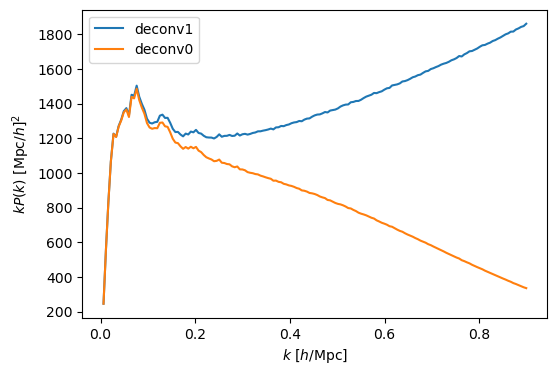

(Array(3.91776232e-17, dtype=float64),)

In [ ]:
# delta_obs0 = jnp.load(load_dir / f'tracer_6746545_paint2_deconv1_{576}.npy') - 1

from montecosmo.plot import plot_mesh, plot_pow, theme
from montecosmo.metrics import spectrum
from montecosmo.nbody import rectangular_hat, deconv_paint, rfftk


kvec = rfftk(delta_obs0.shape)
delta_obs1 = jnp.fft.rfftn(delta_obs0)
delta_obs1 *= rectangular_hat(kvec, order=2)
delta_obs1 = jnp.fft.irfftn(delta_obs1)


box_size = np.array(3*(2000,))  # Mpc/h
kpow0 = spectrum(delta_obs0, box_size=box_size)
kpow1 = spectrum(delta_obs1, box_size=box_size)

plt.figure(figsize=(6,4))
plot_pow(*kpow0, label='deconv1')
plot_pow(*kpow1, label='deconv0')
plt.legend()
plt.show()
delta_obs0.mean(), 

In [ ]:
model.reset()
params_ = dict(jnp.load(save_dir / f'params_mode_{model.mesh_shape[0]}.npz'))
print("Final params:\n", params_, '\n', model.reparam(params_))
truth1 = model.predict(samples=truth | params_ | {'ngbars':1000}, hide_base=False, hide_samp=False, from_base=True)
delta_obs1 = truth1['obs']

Final params:
 {'b1_': array(11.76061254), 'b2_': array(2.53433619), 'bn2_': array(0.69443178), 'bs2_': array(-3.26317035)} 
 {'b1': Array(1.11760613, dtype=float64), 'b2': Array(0.25343362, dtype=float64), 'bs2': Array(-0.32631704, dtype=float64), 'bn2': Array(0.69443178, dtype=float64)}


## Lapprox

In [ ]:
from jax.example_libraries.optimizers import adam
from tqdm import tqdm
lr0 = 1.
n_epochs = 500
energies = []

lr_fn = lambda i: lr0 / (1 + i)**.5
opt_init, opt_update, get_params = adam(lr_fn)
opt_state = opt_init(params_start_)
# opt_state = opt_init(params)

def step(step, opt_state):
    value, pot_grad = potential_valgrad(get_params(opt_state))
    opt_state = opt_update(step, pot_grad, opt_state)
    return value, opt_state

for i_epoch in tqdm(range(n_epochs)):
    value, opt_state = step(i_epoch, opt_state)
    energies.append(float(value))
params_ = get_params(opt_state)
jnp.savez(save_dir / f'params_mode_{model.mesh_shape[0]}.npz', **params_)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:08<00:00,  7.29it/s]


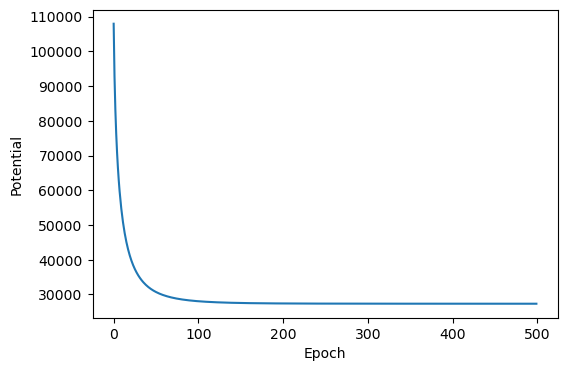

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energies)
plt.xlabel("Epoch"), plt.ylabel("Potential")
plt.show()

Chains(data={'b2': Array(0.18354903, dtype=float64), 'b1': Array(1.2183641, dtype=float64), 'bn2': Array(-22.77584076, dtype=float64), 'bs2': Array(0.01984765, dtype=float64)}, groups={}, labels={})


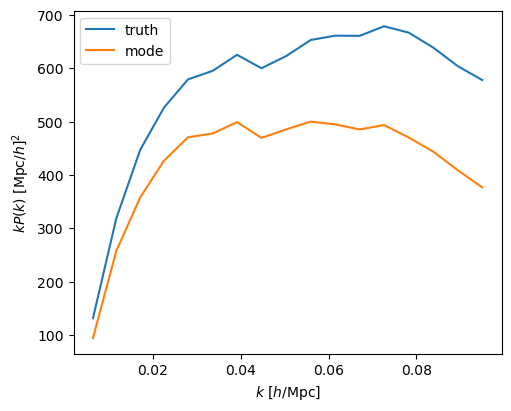

In [ ]:
from montecosmo.chains import Chains
params_ = dict(jnp.load(save_dir / f'params_mode_{model.mesh_shape[0]}.npz'))
post_mode = Chains(model.reparam(params_))
theta_mode, init_mode = post_mode[['*~init_mesh'],'init_mesh']
print(theta_mode)
plt.figure(figsize=(5, 4), layout="constrained")
plot_pow(*model.spectrum(truth['init_mesh']), label='truth')
plot_pow(*model.spectrum(init_mode), label='mode')
plt.legend();

In [ ]:
from montecosmo.chains import Chains
from montecosmo.lapprox import cov_x_from_pot_x_y

theta, tmesh = Chains(params_)[['*~init_mesh_'],['init_mesh_']]
(theta, unravel), (tmesh, _) = theta.ravel(0), tmesh.ravel(0)
names = list(unravel(theta).keys())
labels = [model.labels[k] for k in names]

def pot_fn(theta, mesh):
    params = unravel(theta) | {"init_mesh_": mesh}
    return model.potential(params.data)

cov_x, schur = cov_x_from_pot_x_y(pot_fn, theta, tmesh, method='hutchinson', chunk_size=128)
jnp.save(save_dir / f'cov_mode_{model.mesh_shape[0]}.npy', cov_x)
jnp.save(save_dir / f'schur_mode_{model.mesh_shape[0]}.npy', schur)
print(jnp.linalg.eigvalsh(cov_x))

[-1.11442354e-03  7.03347360e-03  1.42559890e-02  7.91406757e+00]


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/getdist/gaussian_mixtures.py:39: RuntimeWarning: invalid value encountered in sqrt
  self.norms = (2 * np.pi) ** (0.5 * self.dim) * np.array([np.sqrt(np.linalg.det(cov)) for cov in self.covs])


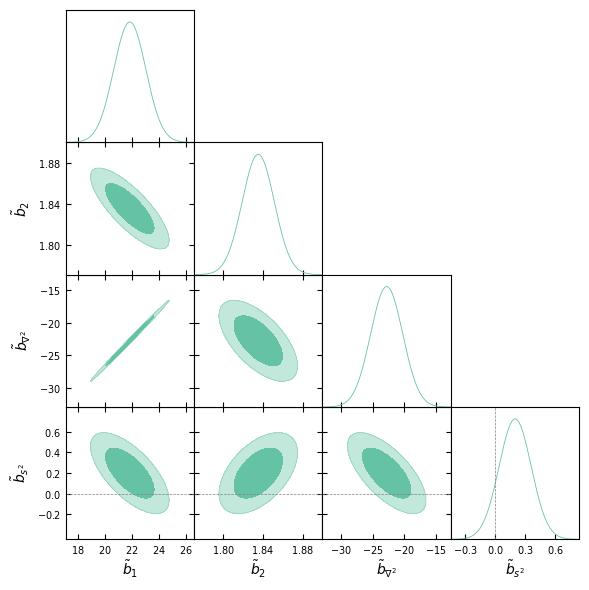

In [ ]:
%matplotlib inline
from getdist import plots, gaussian_mixtures
from montecosmo.plot import SetDark2

gd_fisher = gaussian_mixtures.GaussianND(theta, cov_x, names=names, labels=labels, label='Full Lapprox')
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(gd_fisher, 
                filled=True, 
                contour_colors=[SetDark2(0)], 
                markers=truth)

In [ ]:
n_chains = 2
model.reset()
truth2 = model.predict(samples=(2,30), hide_base=True, hide_samp=True, from_base=True)

In [ ]:
batch_ndim = 2
theta = Chains(truth2, model.groups_)[['*~init_mesh_','~init_mesh','~obs']]
out, unravel = theta.ravel(1)
print(theta.shape)
print(out.shape)
print(unravel(out).shape)

{'Omega_m_': (2, 30), 'alpha_ap_': (2, 30), 'alpha_iso_': (2, 30), 'b1_': (2, 30), 'b2_': (2, 30), 'bn2_': (2, 30), 'bnp_': (2, 30), 'bs2_': (2, 30), 'fNL_': (2, 30), 'ngbars_': (2, 30, 1), 'sigma8_': (2, 30)}
(2, 330)
{'Omega_m_': (2, 30), 'alpha_ap_': (2, 30), 'alpha_iso_': (2, 30), 'b1_': (2, 30), 'b2_': (2, 30), 'bn2_': (2, 30), 'bnp_': (2, 30), 'bs2_': (2, 30), 'fNL_': (2, 30), 'ngbars_': (2, 30, 1), 'sigma8_': (2, 30)}


Removed no burn in


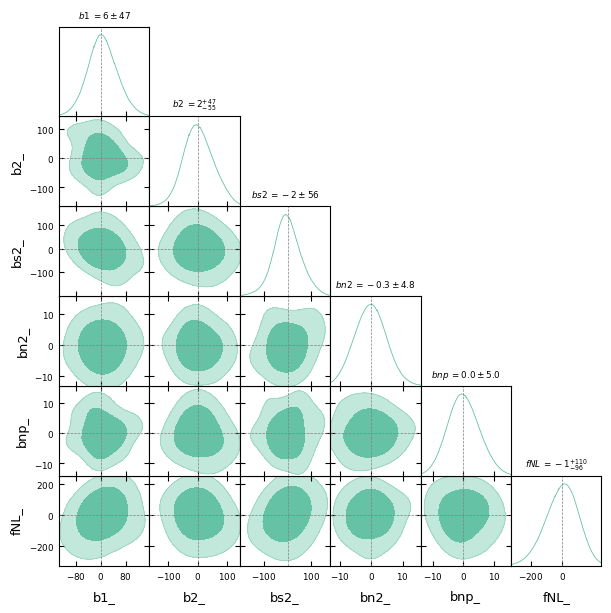

In [ ]:
from getdist import plots
from montecosmo.plot import SetDark2
gdsamp = theta[['bias_']].to_getdist()
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)